In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import geopandas as gpd
import pandas as pd
import os
import copy
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [26]:
def ETa_Linear_NDVI(Hourly_df_with_NDVI_ETa, ETa_col='predicted_PS_ETa_hourly', NDVI_col='NDVI', inplace=False):
    df = Hourly_df_with_NDVI_ETa
    df_out = df if inplace else df.copy()
    # get hour for each row
    hours = df_out.index.hour

    # compute per‐hour mins and maxes, aligned to original index
    min1 = df_out[ETa_col].groupby(hours).transform('min')
    max1 = df_out[ETa_col].groupby(hours).transform('max')
    min2 = df_out[NDVI_col].groupby(hours).transform('min')
    max2 = df_out[NDVI_col].groupby(hours).transform('max')

    # slope m = Δcol1 / Δcol2, avoid div-by-zero by treating zero‐ranges as m=0
    delta2 = max2 - min2
    m = (max1 - min1) / delta2.replace(0, np.nan)
    m = m.fillna(0)

    # intercept b so that at col2=min2 → col1=min1
    b = min1 - m * min2

    # apply the linear mapping in one vectorized operation
    df_out[ETa_col] = df_out[NDVI_col] * m + b

    return df_out

In [2]:
def predict_and_append_to_df(prepared_AORC_PS_NDVI_df, input_features_list, ML_model):
    df = prepared_AORC_PS_NDVI_df.copy()
    X = df[input_features_list].values
    predicted_PS_ETa_hourly = ML_model.predict(X)

    # add the prediction to the original df
    df['predicted_PS_ETa_hourly'] = predicted_PS_ETa_hourly

    return df

In [3]:
# load the trained model
lgbm_model_dir = os.path.join(os.path.dirname(os.getcwd()), '7_MLModel', 'ScenarioB_lgbm_final_model_001.txt')
lgbm_model = lgb.Booster(model_file=lgbm_model_dir)

# input expected by the trained model
input_features_list = lgbm_model.feature_name()

In [4]:
input_features_list = ['NDVI',
 'Air_Temperature',
 'relative_humidity',
 'Downward_Short-Wave_Radiation_Flux']

### Prediction for specific dates

In [24]:
Specific_dates_to_predict_dir = os.path.join(os.path.dirname(os.getcwd()),
                                                               '8_Data_prepration_prediction_phase', 'Specific_dates_to_predict')

for csv_file in os.listdir(Specific_dates_to_predict_dir):
    #if csv_file=='Hourly_AORC_PS_NDVI_per_Day_2022-08-03_US_GBF.csv':
        gs_date = csv_file[28:38]
        AORC_PS_NDVI_gs_date_hourly_df = pd.read_csv(os.path.join(Specific_dates_to_predict_dir, csv_file), index_col=0,parse_dates=[0])
        AORC_PS_NDVI_gs_date_hourly_df.rename(columns={'Air Temperature': 'Air_Temperature', 'Downward Short-Wave Radiation Flux': 'Downward_Short-Wave_Radiation_Flux'}, inplace=True)
        #AORC_PS_NDVI_gs_date_hourly_df['hour_of_day'] = AORC_PS_NDVI_gs_date_hourly_df.index.hour
        AORC_PS_NDVI_gs_date_hourly_df_with_predictions = predict_and_append_to_df(AORC_PS_NDVI_gs_date_hourly_df, input_features_list, lgbm_model)
        gs_data_df = AORC_PS_NDVI_gs_date_hourly_df_with_predictions[['longitude', 'latitude', 'NDVI', 'predicted_PS_ETa_hourly']]

        # bais correction based on NDVI
        gs_data_df_bc = ETa_Linear_NDVI(gs_data_df)
        gs_data_df_bc.to_csv(f'{csv_file[:-4]}_with_ETa_predictions.csv')

In [14]:
gs_data_df

longitude   latitude      NDVI  predicted_PS_ETa_hourly
2022-08-03 06:00:00 -77.992353  40.762355  0.915499                 0.087313
2022-08-03 06:00:00 -77.992317  40.762354  0.917482                 0.087313
2022-08-03 06:00:00 -77.992282  40.762353  0.913850                 0.087313
2022-08-03 06:00:00 -77.992246  40.762352  0.907887                 0.087313
2022-08-03 06:00:00 -77.992211  40.762351  0.903730                 0.086795
...                        ...        ...       ...                      ...
2022-08-03 18:00:00 -78.014841  40.748213  0.783949                 0.184589
2022-08-03 18:00:00 -78.014805  40.748212  0.795105                 0.184589
2022-08-03 18:00:00 -78.014770  40.748211  0.789992                 0.184589
2022-08-03 18:00:00 -78.014734  40.748210  0.781867                 0.184589
2022-08-03 18:00:00 -78.014699  40.748209  0.772216                 0.184485

[4583839 rows x 4 columns]

In [96]:
input_features_list = ['NDVI',
 'Air_Temperature',
 'relative_humidity',
 'Downward_Short-Wave_Radiation_Flux']

Specific_dates_to_predict_dir = os.path.join(os.path.dirname(os.getcwd()),
                                                               '8_Data_prepration_prediction_phase', 'Specific_dates_to_predict')

for csv_file in os.listdir(Specific_dates_to_predict_dir):
    if csv_file=='Hourly_AORC_PS_NDVI_per_Day_2024-05-31_US_GBF.csv':
        gs_date = csv_file[28:38]
        AORC_PS_NDVI_gs_date_hourly_df = pd.read_csv(os.path.join(Specific_dates_to_predict_dir, csv_file), index_col=0,parse_dates=[0])
        AORC_PS_NDVI_gs_date_hourly_df.rename(columns={'Air Temperature': 'Air_Temperature', 'Downward Short-Wave Radiation Flux': 'Downward_Short-Wave_Radiation_Flux'}, inplace=True)
        #AORC_PS_NDVI_gs_date_hourly_df['hour_of_day'] = AORC_PS_NDVI_gs_date_hourly_df.index.hour
        AORC_PS_NDVI_gs_date_hourly_df_with_predictions = predict_and_append_to_df(AORC_PS_NDVI_gs_date_hourly_df, input_features_list, lgbm_model)
        gs_data_df = AORC_PS_NDVI_gs_date_hourly_df_with_predictions[['longitude', 'latitude', 'NDVI', 'predicted_PS_ETa_hourly']]

        # bais correction based on NDVI
        gs_data_df_bc = ETa_Linear_NDVI(gs_data_df)
        gs_data_df_bc.to_csv(f'{csv_file[:-4]}_with_ETa_predictions.csv')

### Prediction to extract average predicted ETa for ffp

In [5]:
# Define a function to calculate NSE
def nse(predicted, actual):
    if sum((actual - actual.mean()) ** 2)==0:
        return np.nan
    return 1 - (sum((actual - predicted) ** 2) / sum((actual - actual.mean()) ** 2))

def kge(predicted, actual):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)

    r = np.corrcoef(actual, predicted)[0, 1]  # Correlation
    beta = np.mean(predicted) / np.mean(actual)
    gamma = (np.std(predicted) / np.mean(predicted)) / (np.std(actual) / np.mean(actual))
    
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge


def calculate_daily_metrics(results_df, actual_col, predicted_col):
    """
    Calculate daily error metrics (MAE, RMSE, NSE) for each day in the dataframe.
    
    Parameters:
    - results_df: pandas DataFrame with a DateTime index, containing 'Actual' and 'Predicted' columns.

    Returns:
    - daily_metrics: dict with DatePeriod as keys and metrics (MAE, RMSE, NSE) as values.
    """
    daily_metrics = {}
    
    for day, day_group in results_df.groupby(results_df.index.to_period('D')):
        day_group = day_group.dropna(subset=[actual_col, predicted_col])
        if day_group[actual_col].empty:
            return {}
        mae = mean_absolute_error(day_group[actual_col], day_group[predicted_col])
        rmse = np.sqrt(mean_squared_error(day_group[actual_col], day_group[predicted_col]))
        nse_value = nse(day_group[predicted_col], day_group[actual_col])
        kge_value = kge(day_group[predicted_col], day_group[actual_col])
        
        daily_metrics[day] = {
            'MAE': mae,
            'RMSE': rmse,
            'NSE': nse_value,
            'KGE': kge_value
        }
    
    return daily_metrics

In [6]:
def weekly_plots_with_error_metrics(df, actual_col_name, predicted_col_name, Scenario_model, savefig=False):

    # Group by week and plot
    for week, group in df.groupby(df.index.to_period('W')):
        daily_metrics = calculate_daily_metrics(group, actual_col_name, predicted_col_name)

        # Create a mask to filter out NaNs in either array
        mask = ~np.isnan(group[actual_col_name]) & ~np.isnan(group[predicted_col_name])

        # Compute R² using only the valid entries
        #r2 = r2_score(y_true[mask], y_pred[mask])
        mae = r2_score(group[actual_col_name][mask], group[predicted_col_name][mask])
        plt.figure(figsize=(8, 2))
        plt.scatter(group.index, group[actual_col_name], label='Actual ETa',marker='o', s=20, color='darkgreen', alpha=0.8)
        plt.scatter(group.index, group[predicted_col_name], label='Predicted ETa', marker='x', s=20, color='darkblue', alpha=0.8)
        plt.ylim(-0.02, 1)
        plt.xlabel('Time')
        plt.ylabel('ETa (mm/hr)')
        plt.title(f'{Scenario_model}, Week {week}')
        #plt.grid(axis='x')
        
        # Calculate day starts and mids
        day_starts = group.index.normalize().unique()
        day_mids = day_starts + pd.Timedelta(hours=12)
        xtick_labels = [dt.strftime('%m-%d') for dt in day_mids]

        # Set xtick labels at midpoints
        plt.xticks(day_mids, xtick_labels, rotation=0)

        # Set grid lines separately at start of each day
        ax = plt.gca()
        ax.set_xticks(day_starts, minor=True)  # Use minor ticks for grid lines
        ax.grid(True, which='minor', axis='x', linestyle='--', color='gray', alpha=0.4)
        

        # Annotate the plot with daily error metrics
        for day, metrics in daily_metrics.items():
            plt.text(day.start_time + (day.end_time - day.start_time) / 6, 0.95, 
                    f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nNSE: {metrics['NSE']:.2f}\nKGE: {metrics['KGE']:0.2f}",
                    fontsize=9, verticalalignment='top')
        if savefig:
            # Create the filename
            filename = f"{Scenario_model}_Week_{week.strftime('%Y-%m-%d')}_R2_{mae:.2f}.png"
        
            # Ensure the directory exists
            output_dir = "plots"
            os.makedirs(output_dir, exist_ok=True)  # Creates "plots" directory if it does not exist
            plt.savefig(os.path.join(output_dir, filename), dpi=300, transparent=True)
            
        plt.show()

In [7]:
def predict_LGBM(model, X_df, y_df, prediction_col='ETa_predicted'):

    
    preds = model.predict(X_df)
    
    # Create a copy of the DataFrame and add the predictions column.
    df_with_preds = pd.concat([X_df, y_df], axis=1).copy()
    df_with_preds[prediction_col] = preds
    
    return df_with_preds

In [8]:
# load the trained model
lgbm_model_dir = os.path.join(os.path.dirname(os.getcwd()), '7_MLModel', 'ScenarioB_lgbm_final_model_001.txt')
lgbm_model = lgb.Booster(model_file=lgbm_model_dir)

# input expected by the trained model
input_features_list = lgbm_model.feature_name()

In [20]:
train_file_UC1 = os.path.join(os.path.dirname(os.getcwd()),'6_Data_aggregation',
                             'US_UC1_Hourly_ECT_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test.csv')  # Change to your training file path

train_file_UC2 = os.path.join(os.path.dirname(os.getcwd()),'6_Data_aggregation',
                             'US_UC2_Hourly_ECT_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test.csv')  # Change to your training file path

# Load the data; ensure that the timestamp column is parsed as dates.
UC1_train_df = pd.read_csv(train_file_UC1, index_col=0, parse_dates=[0])
UC2_train_df = pd.read_csv(train_file_UC2, index_col=0, parse_dates=[0])

train_df = pd.concat([UC1_train_df, UC2_train_df])

# Drop observations with nan NDVI values or flag==1 or ET_corr nan values
train_df_filtered = train_df[(train_df['NDVI']>0) & (train_df['ETa_corr']>0) & (train_df['ffp_intersection_flag']==0)]

train_df_filtered = train_df_filtered.rename(columns={'TA_1_1_1': 'Air Temperature', 'RH_1_1_1': 'relative_humidity',
                                                      'SW_IN_1_1_1':'Downward Short-Wave Radiation Flux',
                                                      'LW_IN_1_1_1':'Downward Long-Wave Radiation Flux',
                                                      'WS':'Wind Speed', 'PA':'Air Pressure',
                                                      'P_RAIN_1_1_1':'Total Precipitation'})

# Drop 'Downward Long-Wave Radiation Flux' and 'Total Precipitation' based on HXGB001 results
train_df_filtered = train_df_filtered.drop(columns=['Downward Long-Wave Radiation Flux', 'Total Precipitation', 'Wind Speed', 'Air Pressure'])

# train X and y
X_train_val = train_df_filtered.drop(columns=['ETa_corr', 'ffp_intersection_flag', 'ETa_NaN_flag'])  # Training features
y_train_val = train_df_filtered['ETa_corr']  # Training target

#### Test at train site

In [104]:
UC1_AORC_train_file = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_UC1_Hourly_AORC_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test.csv')
UC2_AORC_train_file = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_UC2_Hourly_AORC_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test.csv')

# Load the data; ensure that the timestamp column is parsed as dates.
UC1_AORC_train_df = pd.read_csv(UC1_AORC_train_file, index_col=0, parse_dates=[0])
UC2_AORC_train_df = pd.read_csv(UC2_AORC_train_file, index_col=0, parse_dates=[0])

# Drop observations with nan NDVI values or ET_corr nan values
UC1_AORC_train_df_filtered = UC1_AORC_train_df[(UC1_AORC_train_df['NDVI']>0) & (UC1_AORC_train_df['ETa_corr']>0)]
UC2_AORC_train_df_filtered = UC2_AORC_train_df[(UC2_AORC_train_df['NDVI']>0) & (UC2_AORC_train_df['ETa_corr']>0)]

# List of input feature columns
input_features_list = X_train_val.columns

UC1_X_test_train = UC1_AORC_train_df_filtered[input_features_list]
UC1_y_test_train = UC1_AORC_train_df_filtered['ETa_corr']

UC2_X_test_train = UC2_AORC_train_df_filtered[input_features_list]
UC2_y_test_train = UC2_AORC_train_df_filtered['ETa_corr']

In [128]:
UC1_df_test_w_preds = predict_LGBM(lgbm_model, UC1_X_test_train, UC1_y_test_train, prediction_col='ETa_predicted')
#plot_interactive_scatter_by_year(UC1_df_test_w_preds, 'ETa_corr', 'ETa_predicted')

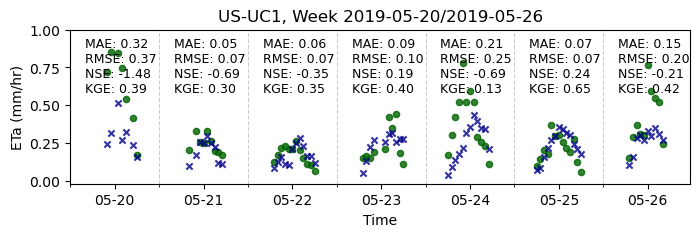

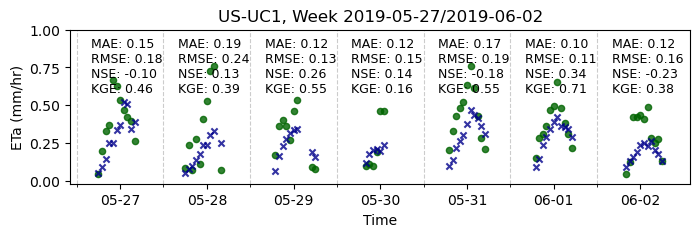

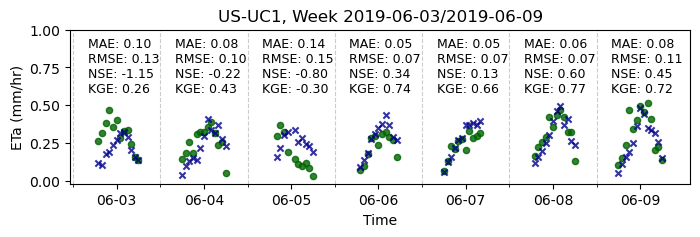

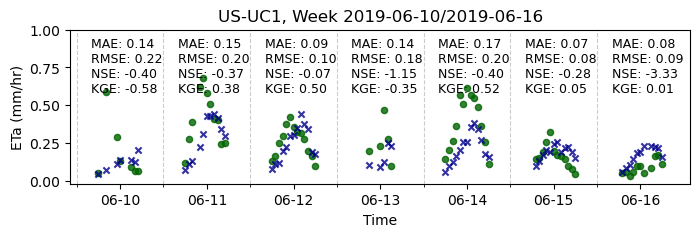

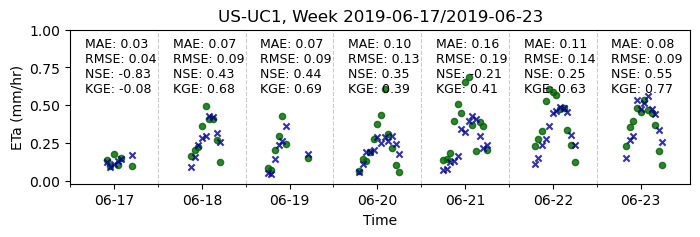

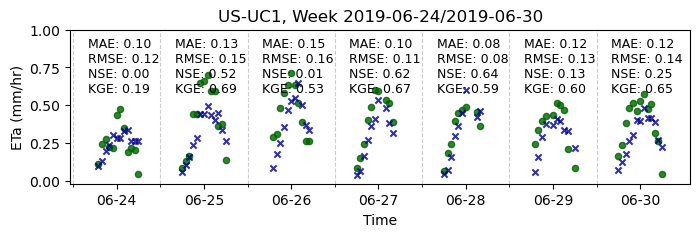

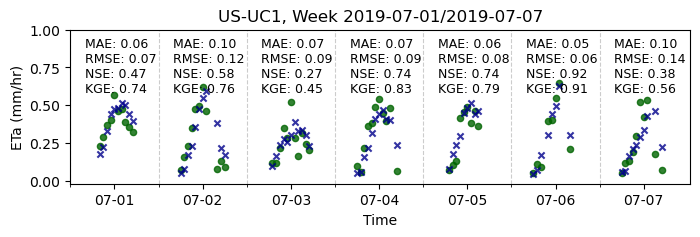

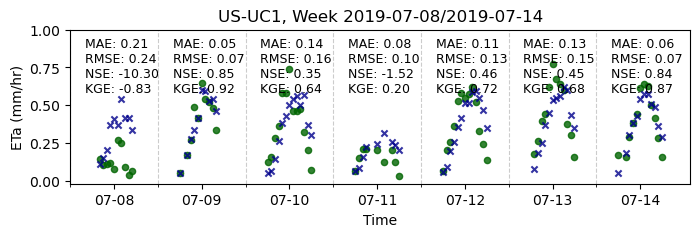

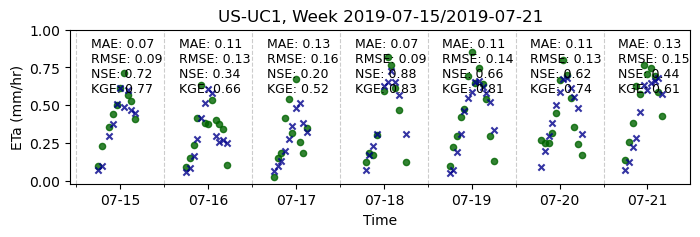

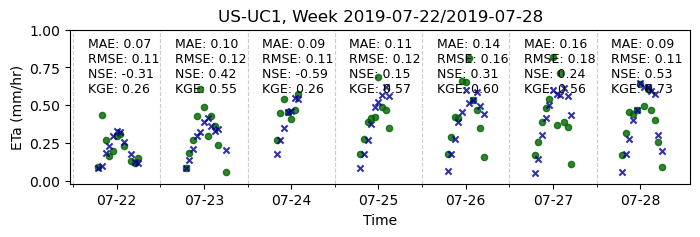

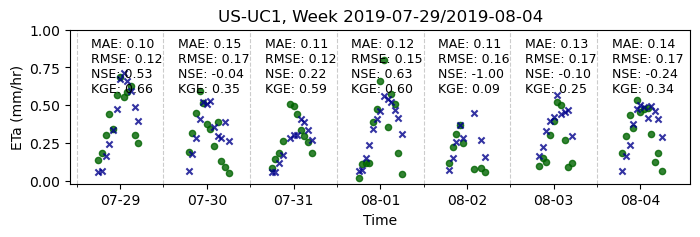

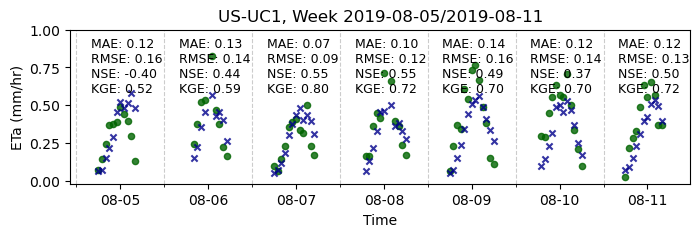

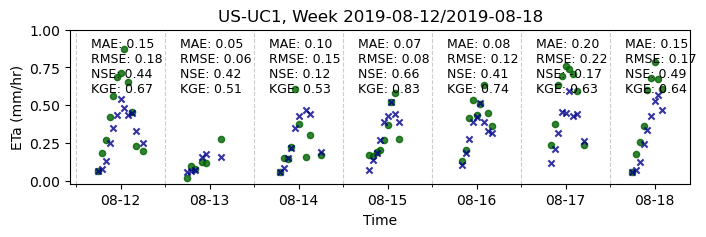

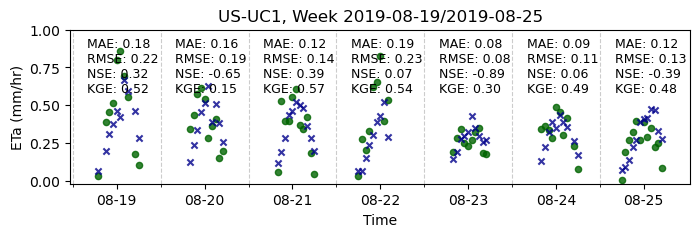

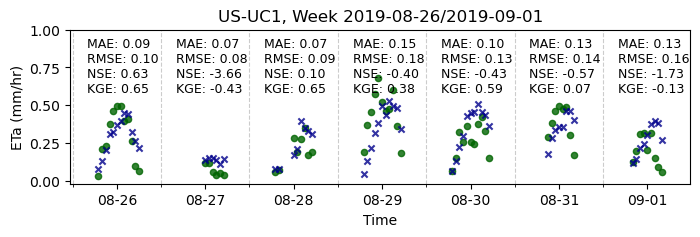

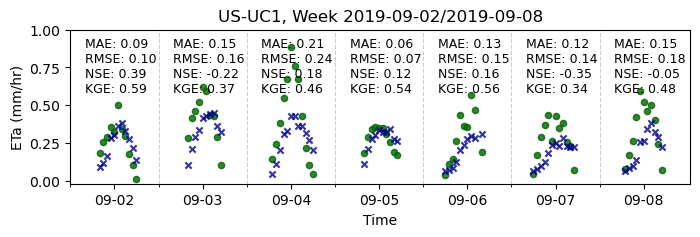

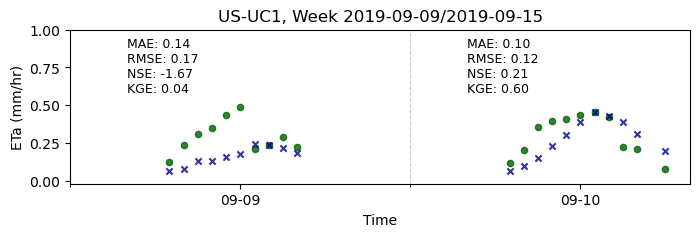

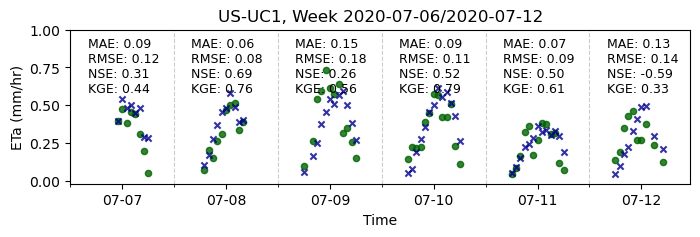

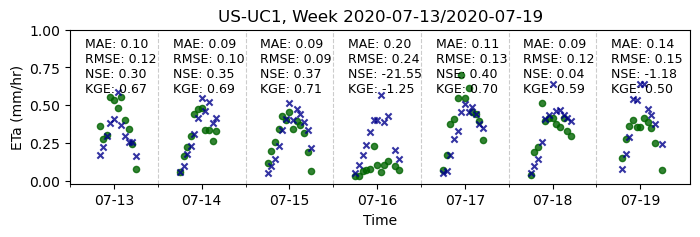

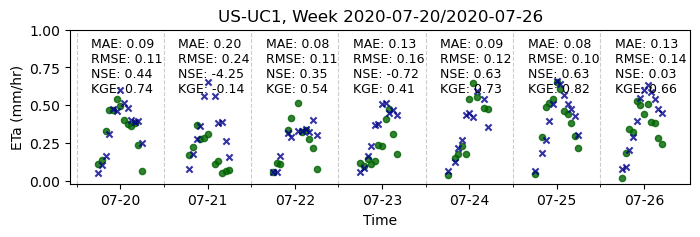

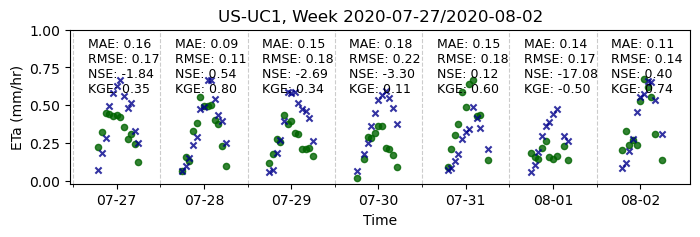

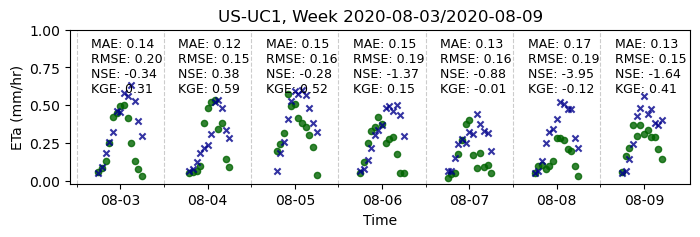

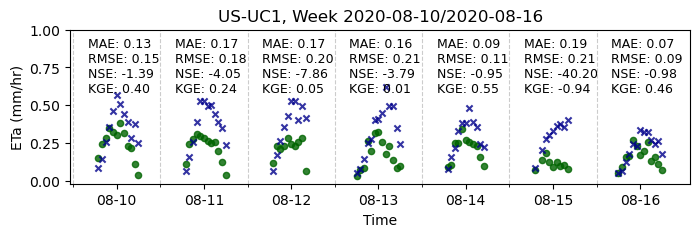

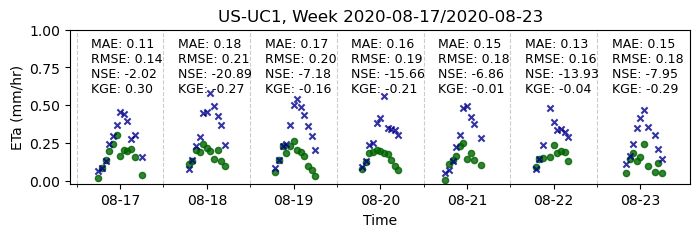

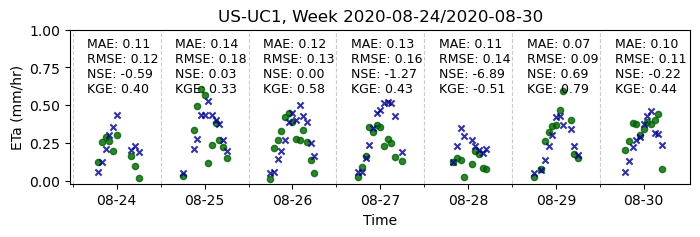

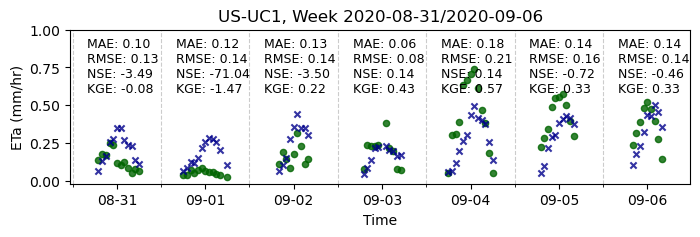

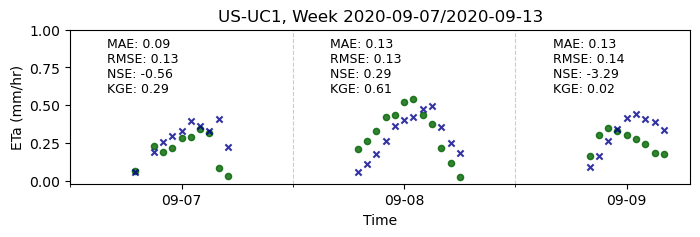

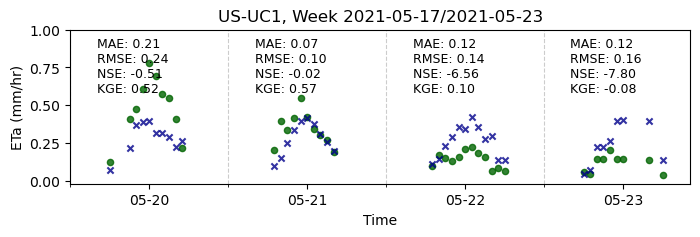

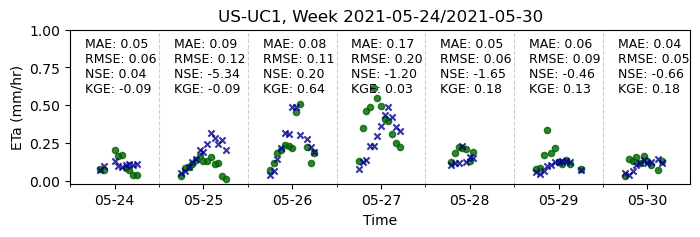

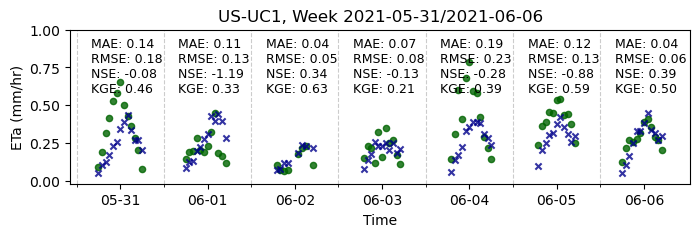

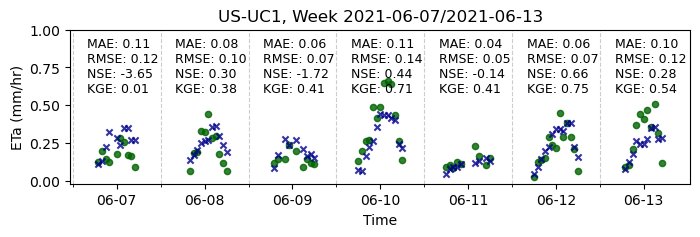

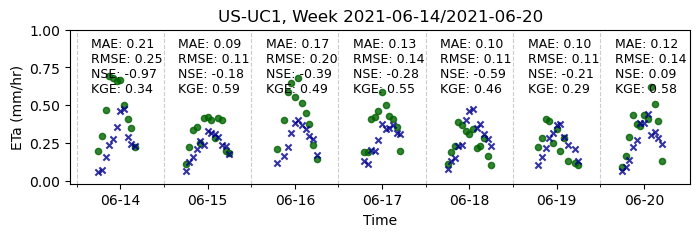

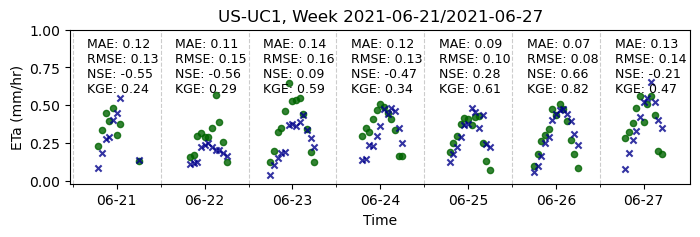

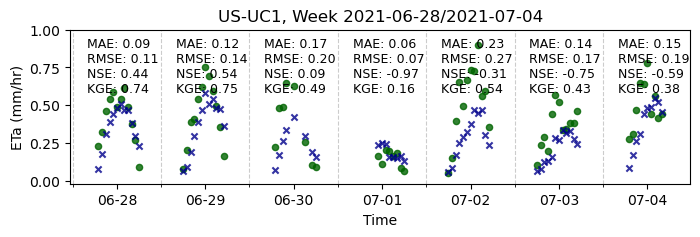

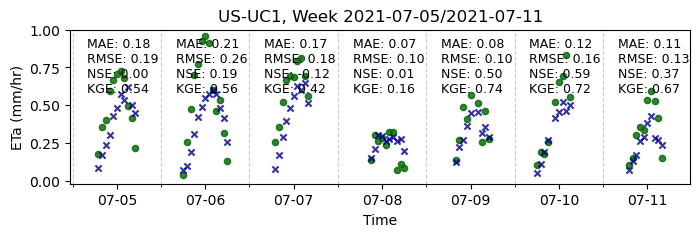

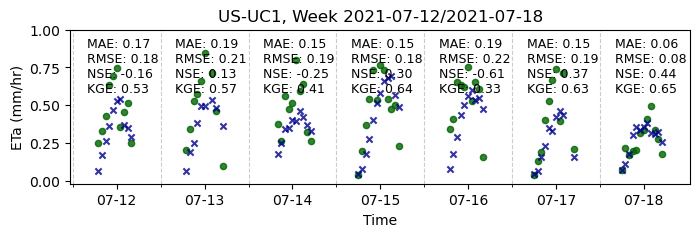

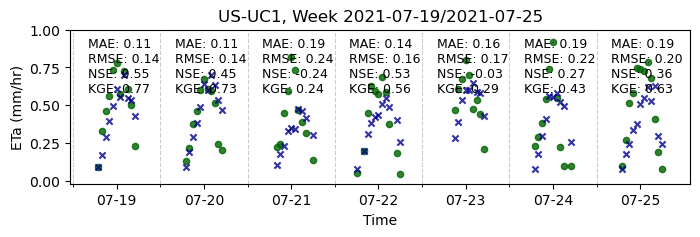

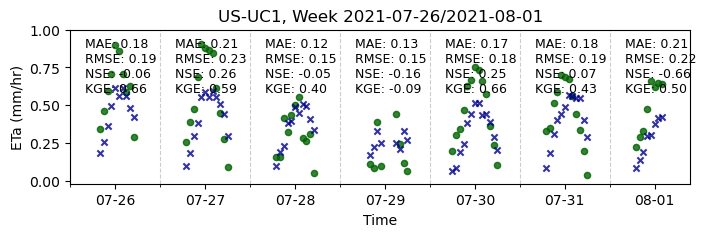

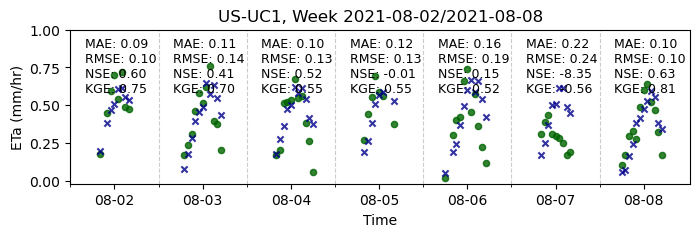

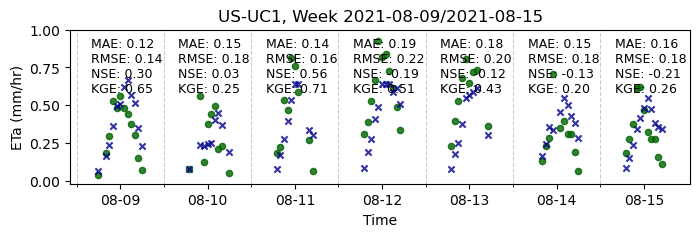

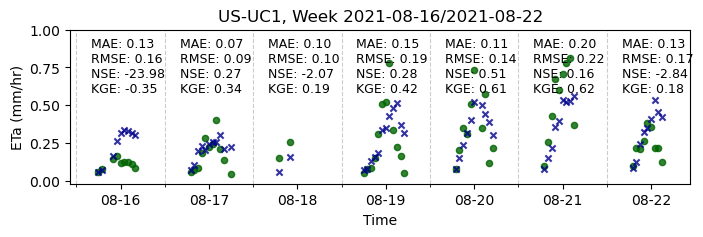

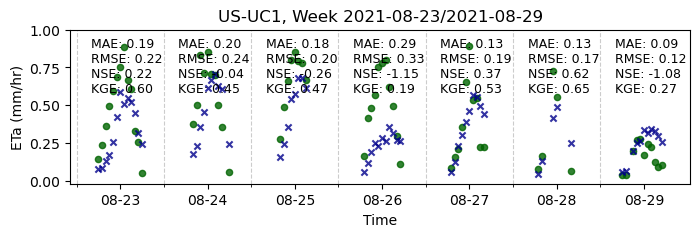

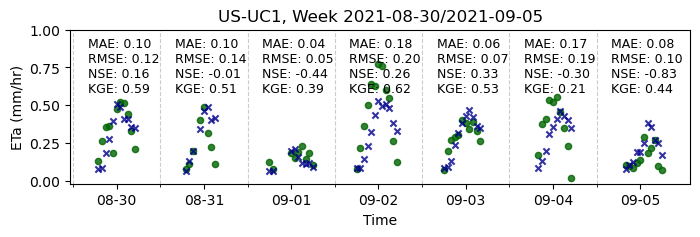

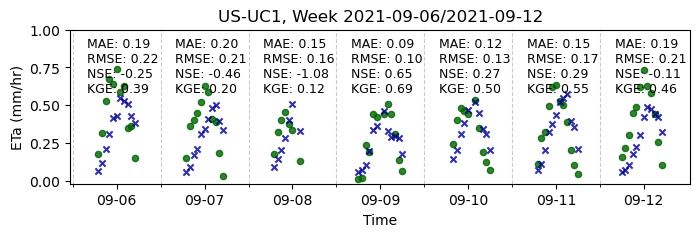

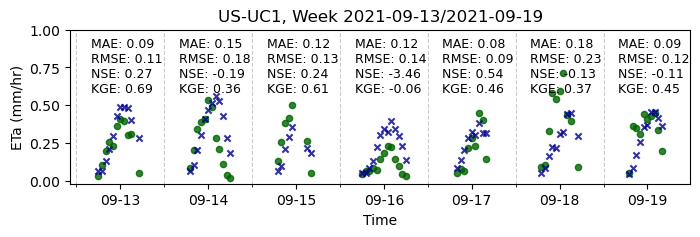

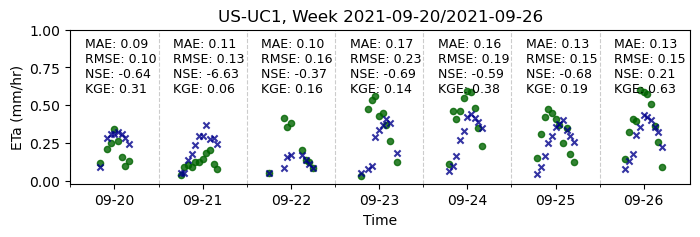

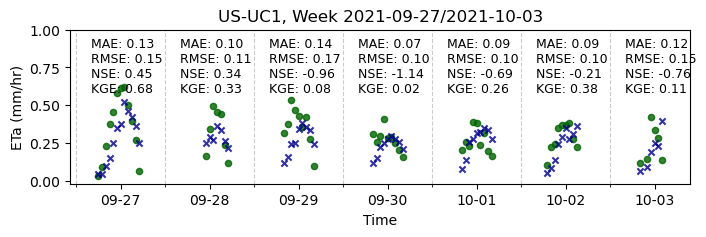

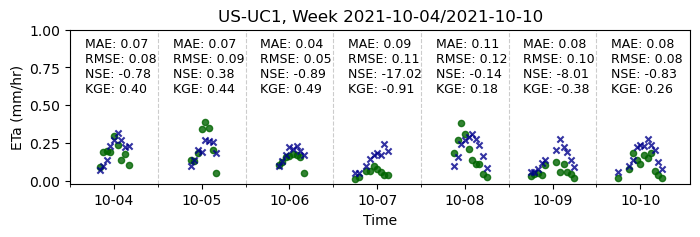

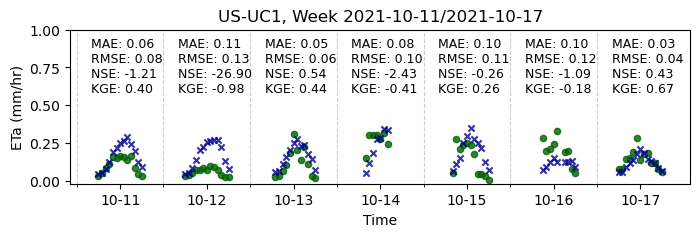

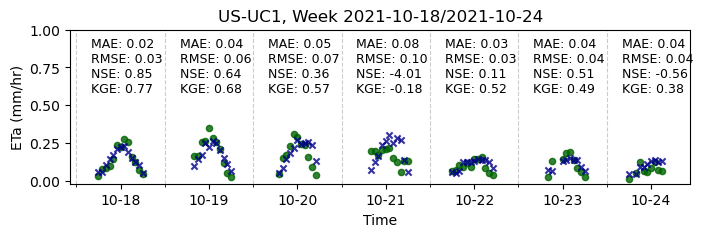

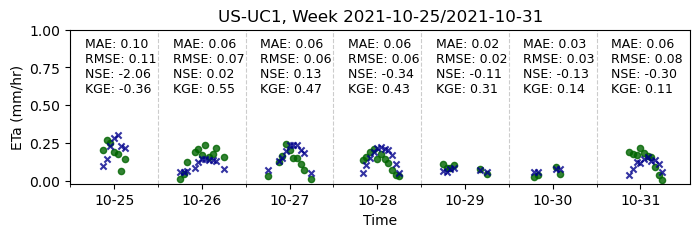

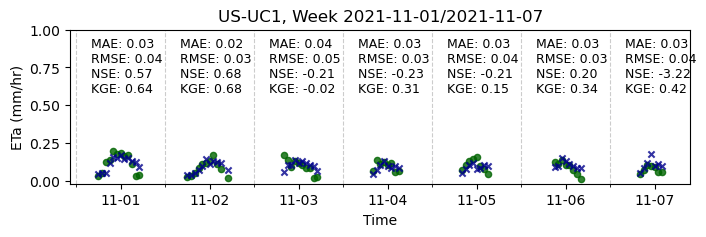

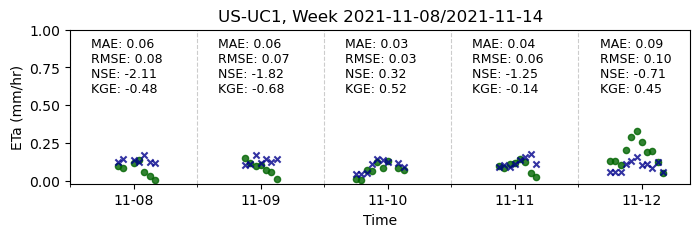

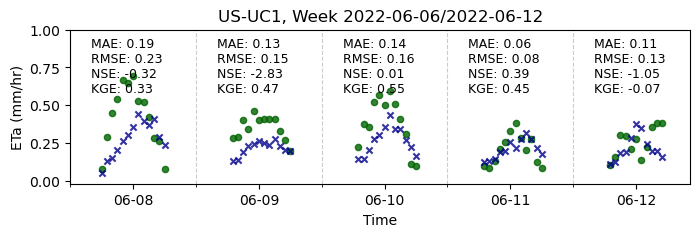

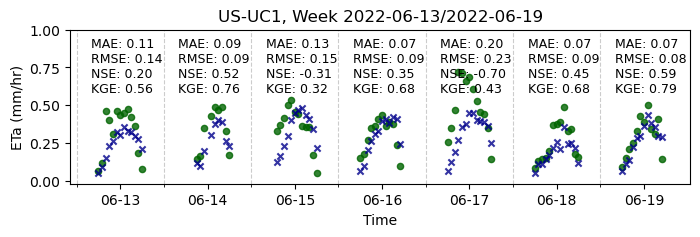

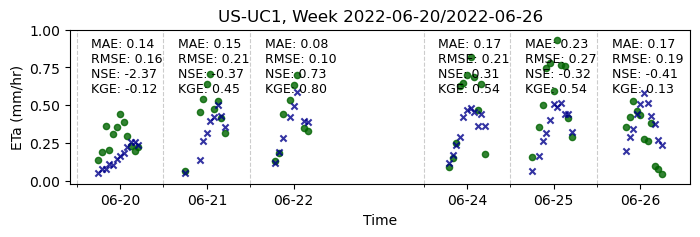

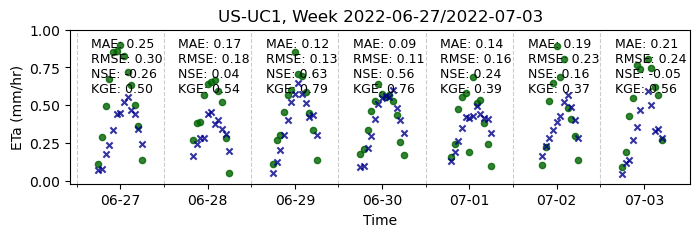

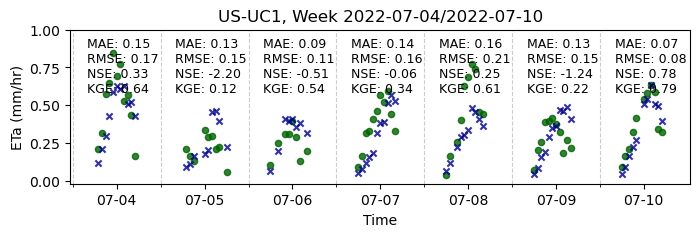

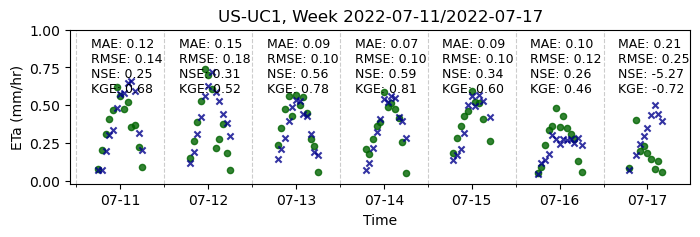

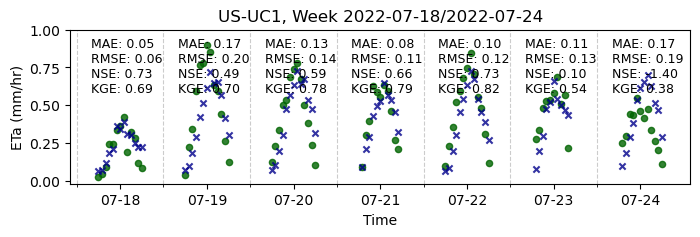

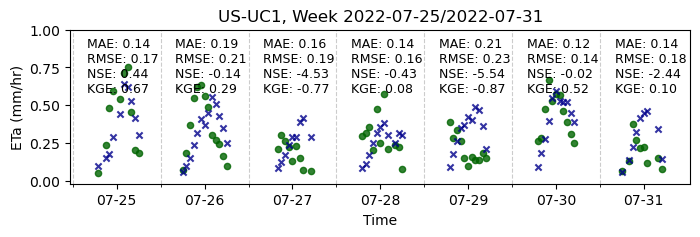

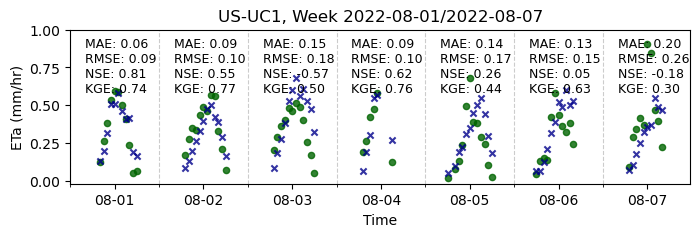

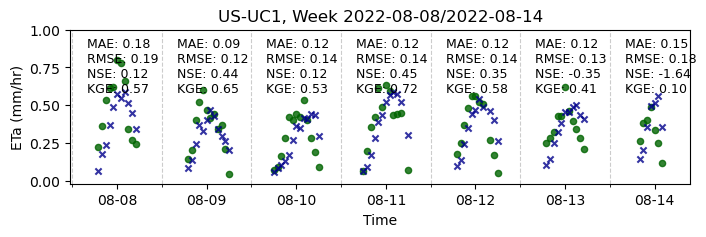

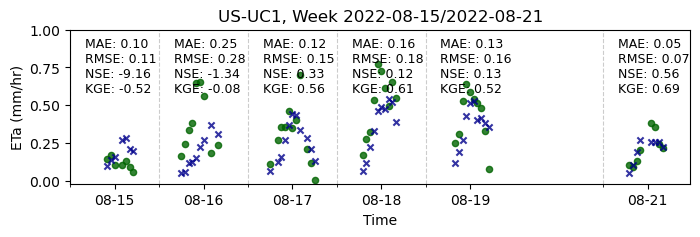

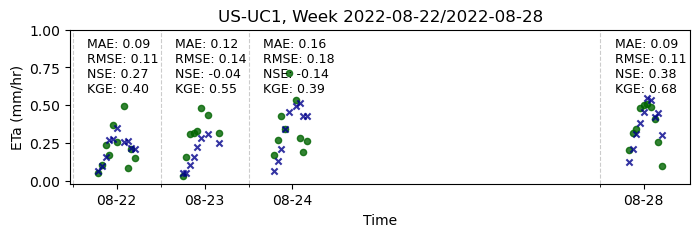

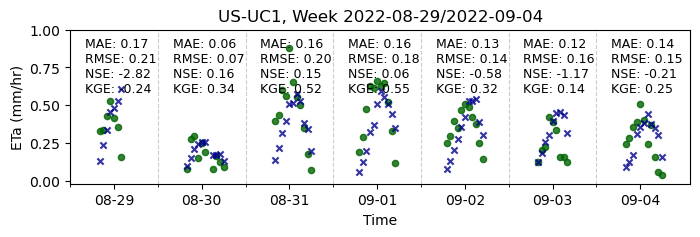

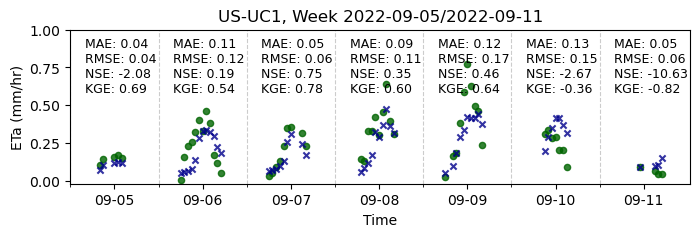

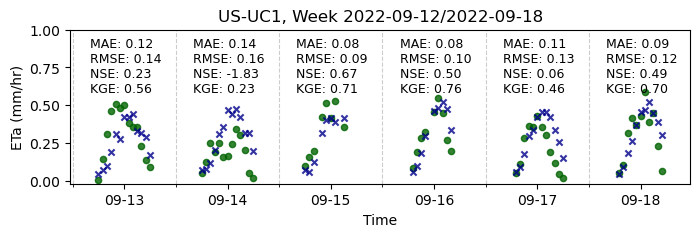

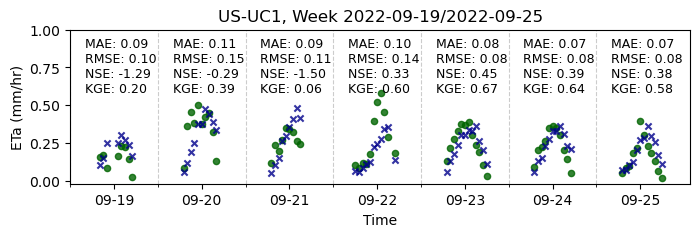

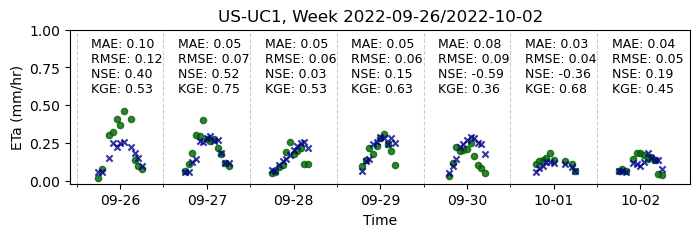

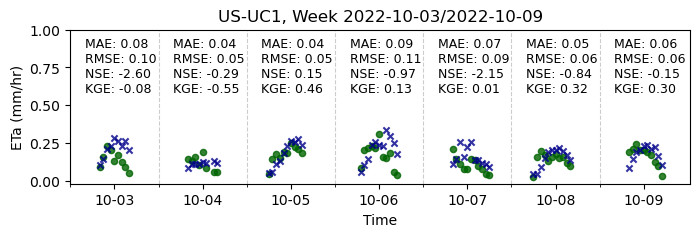

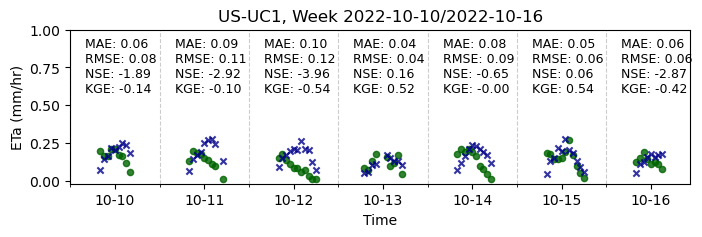

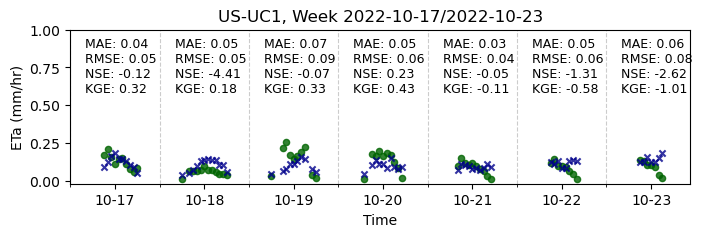

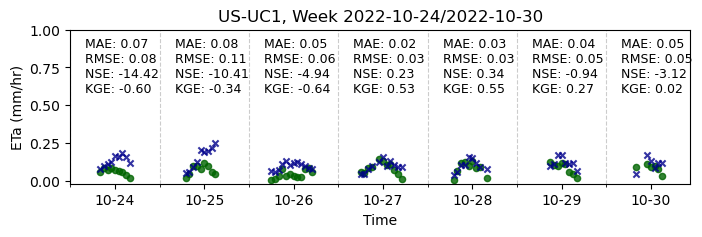

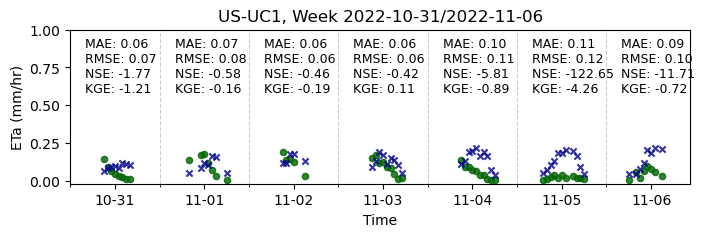

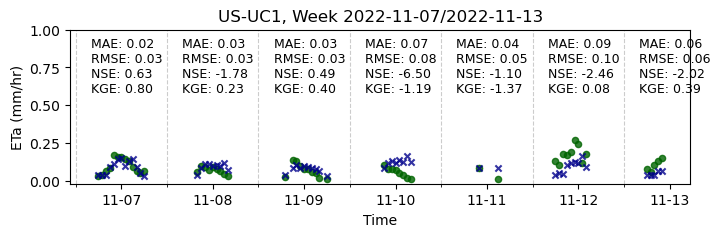

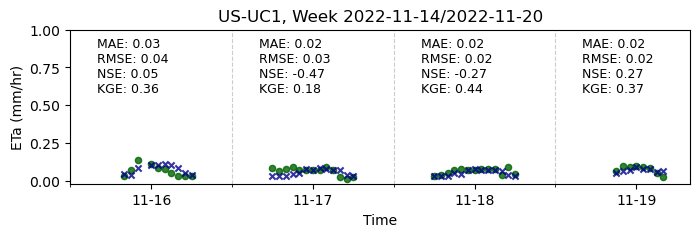

In [106]:
weekly_plots_with_error_metrics(UC1_df_test_w_preds, 'ETa_corr', 'ETa_predicted', 'US-UC1', savefig=False)

In [ ]:
UC2_df_test_w_preds = predict_LGBM(lgbm_model, UC2_X_test_train, UC2_y_test_train, prediction_col='ETa_predicted')
plot_interactive_scatter_by_year(UC2_df_test_w_preds, 'ETa_corr', 'ETa_predicted')

In [ ]:
weekly_plots_with_error_metrics(UC2_df_test_w_preds, 'ETa_corr', 'ETa_predicted', 'US-UC1', savefig=False)

In [ ]:
Tower = 'US-UC2'
year = '2019'

# Assuming df['actual'] and df['predicted'] exist
x = UC2_df_test_w_preds.loc[year]['ETa_corr'].values
y = UC2_df_test_w_preds.loc[year]['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.45)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=1, vmax=6)
plt.colorbar(sc, label='Frequnecy')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f'{Tower}, {year}', fontsize=10)
#plt.legend()
plt.tight_layout()
plt.savefig(f'{Tower}_{year}_Actual_vs_Predcited_ETa_plot_with_colorbar.png', dpi=300, transparent=True)
plt.show()

#### Test at test sites

In [31]:
HWB_test_file = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_HWB_2017_Hourly_AORC_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test.csv')  # Change to your test file path

UC1_test_file = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_UC1_2024_Hourly_AORC_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test.csv')
UC2_test_file = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_UC2_2024_Hourly_AORC_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test.csv')

# Load the data; ensure that the timestamp column is parsed as dates.
HWB_test_df = pd.read_csv(HWB_test_file, index_col=0, parse_dates=[0])
UC1_test_df = pd.read_csv(UC1_test_file, index_col=0, parse_dates=[0])
UC2_test_df = pd.read_csv(UC2_test_file, index_col=0, parse_dates=[0])

# Drop observations with nan NDVI values or ET_corr nan values
HWB_test_df_filtered = HWB_test_df[(HWB_test_df['NDVI']>0) & (HWB_test_df['ETa_corr']>0)]
UC1_test_df_filtered = UC1_test_df[(UC1_test_df['NDVI']>0) & (UC1_test_df['ETa_corr']>0)]
UC2_test_df_filtered = UC2_test_df[(UC2_test_df['NDVI']>0) & (UC2_test_df['ETa_corr']>0)]

# List of input feature columns
input_features_list = X_train_val.columns

# prediction of ETa for each pixel within tower ffp
HWB_X_test = HWB_test_df_filtered[input_features_list]
HWB_y_test = HWB_test_df_filtered['ETa_corr']

UC1_X_test = UC1_test_df_filtered[input_features_list]
UC1_y_test = UC1_test_df_filtered['ETa_corr']

UC2_X_test = UC2_test_df_filtered[input_features_list]
UC2_y_test = UC2_test_df_filtered['ETa_corr']

In [142]:
#UC1_df_test_w_preds.to_csv('UC1_df_test_with_preds.csv')

In [33]:
UC1_df_test_w_preds = predict_LGBM(lgbm_model, UC1_X_test, UC1_y_test, prediction_col='ETa_predicted')
#weekly_plots_with_error_metrics(UC1_df_test_w_preds, 'ETa_corr', 'ETa_predicted', 'US-UC1', savefig=False)

In [34]:
UC2_df_test_w_preds = predict_LGBM(lgbm_model, UC2_X_test, UC2_y_test, prediction_col='ETa_predicted')
#UC2_df_test_w_preds.to_csv('UC2_df_test_with_preds.csv')
#weekly_plots_with_error_metrics(UC2_df_test_w_preds, 'ETa_corr', 'ETa_predicted', 'US-UC2', savefig=False)

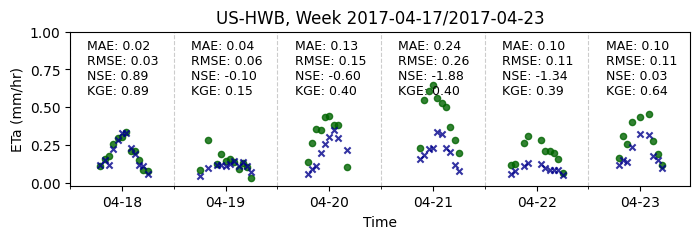

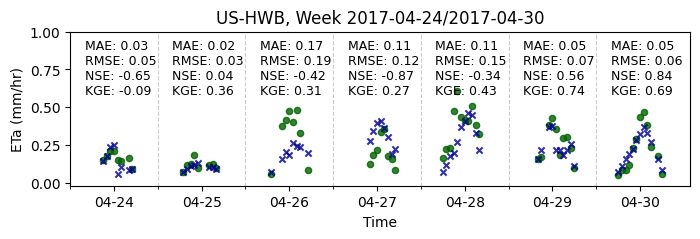

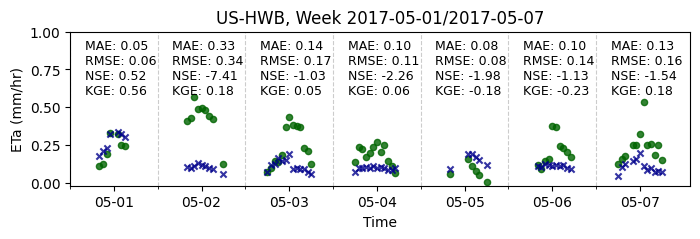

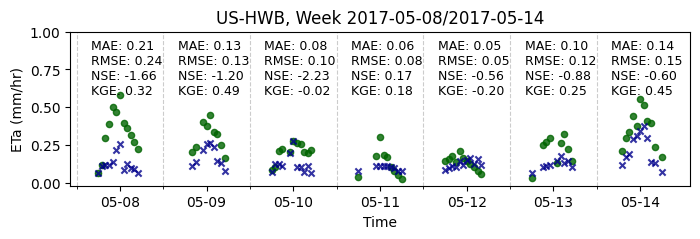

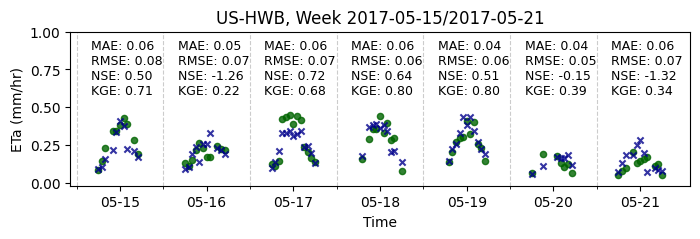

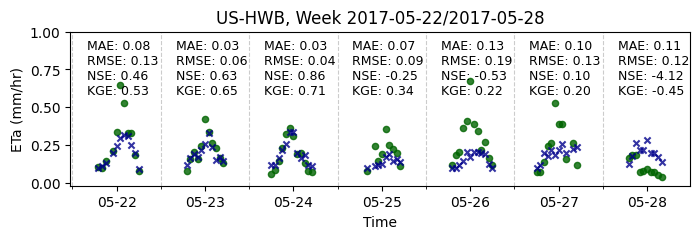

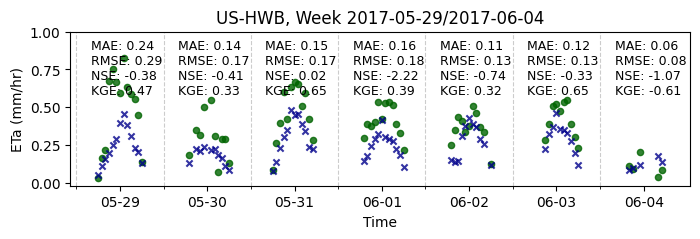

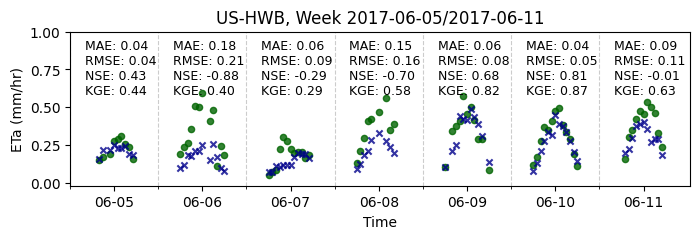

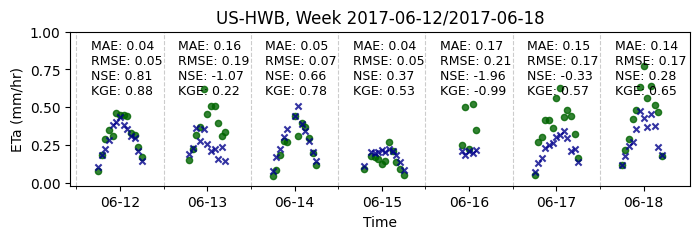

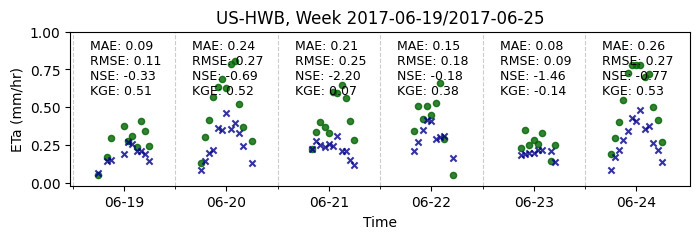

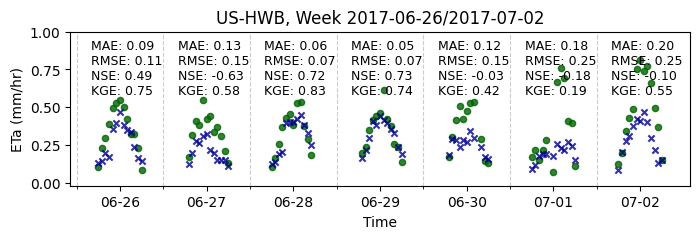

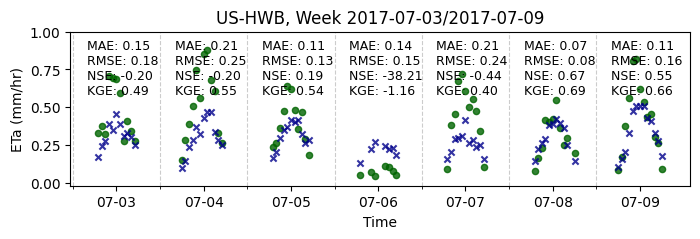

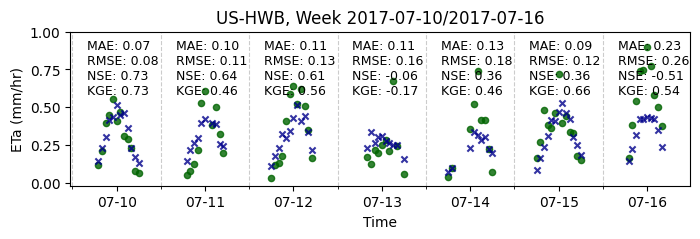

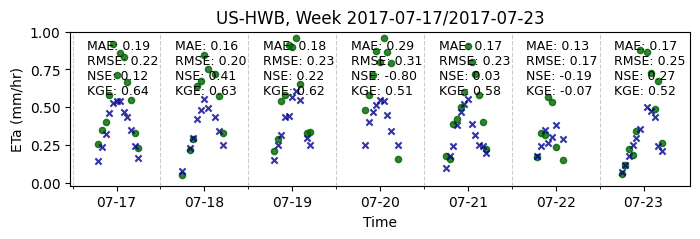

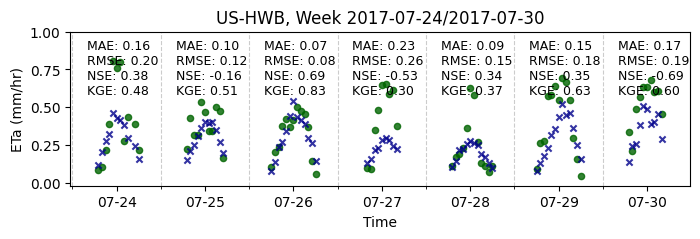

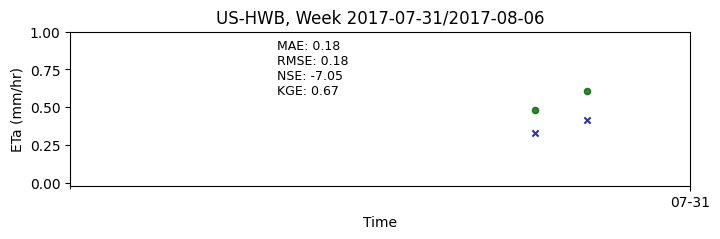

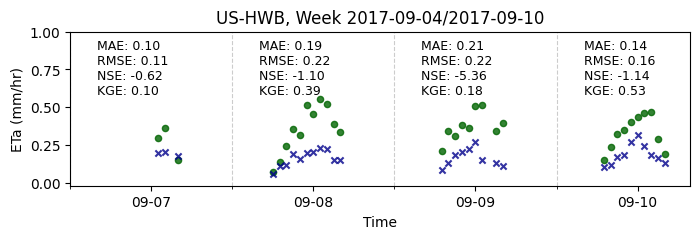

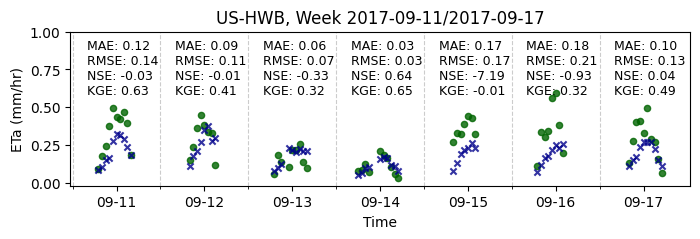

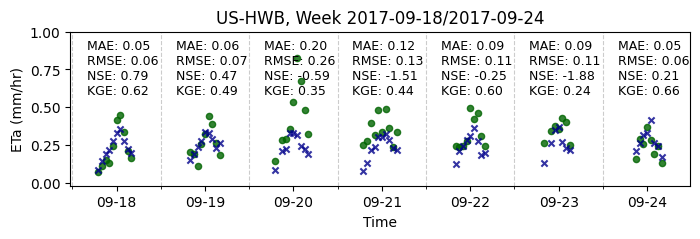

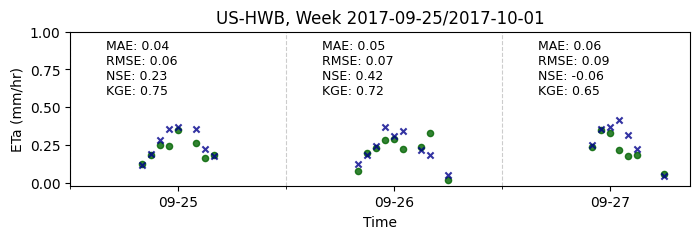

In [22]:
HWB_df_test_w_preds = predict_LGBM(lgbm_model, HWB_X_test, HWB_y_test, prediction_col='ETa_predicted')
#HWB_df_test_w_preds.to_csv('HWB_df_test_with_preds.csv')
weekly_plots_with_error_metrics(HWB_df_test_w_preds, 'ETa_corr', 'ETa_predicted', 'US-HWB', savefig=False)

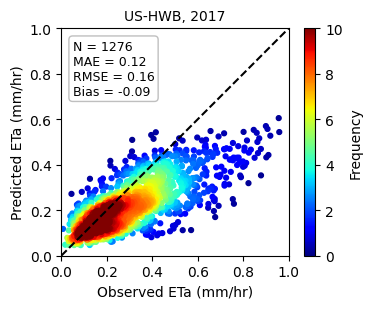

In [68]:
# Assuming df['actual'] and df['predicted'] exist
x = HWB_df_test_w_preds.loc['2017']['ETa_corr'].values
y = HWB_df_test_w_preds.loc['2017']['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequency')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-HWB, 2017', fontsize=10)
#plt.legend()
plt.tight_layout()
plt.savefig('US_HWB_2017_Actual_vs_Predcited_ETa_plot_with_colorbar_AORC_HWB.png', dpi=300, transparent=True)
plt.show()

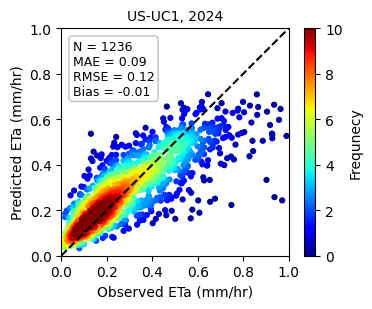

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming df['actual'] and df['predicted'] exist
x = UC1_df_test_w_preds.loc['2024']['ETa_corr'].values
y = UC1_df_test_w_preds.loc['2024']['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequnecy')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-UC1, 2024', fontsize=10)
#plt.legend()
plt.tight_layout()
plt.savefig('US_UC1_2024_Actual_vs_Predcited_ETa_plot_with_colorbar.png', dpi=300, transparent=True)
plt.show()

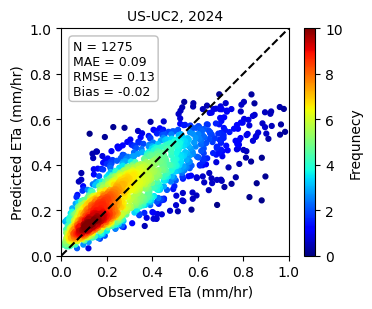

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

common_idx = UC2_df_test_w_preds_ECT.index.intersection(UC2_df_test_w_preds.index)
UC2_df_test_w_preds = UC2_df_test_w_preds.loc[common_idx]

# Assuming df['actual'] and df['predicted'] exist
x = UC2_df_test_w_preds.loc['2024']['ETa_corr'].values
y = UC2_df_test_w_preds.loc['2024']['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequnecy')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-UC2, 2024', fontsize=10)
#plt.legend()
plt.tight_layout()
plt.savefig('US_UC2_2024_Actual_vs_Predcited_ETa_plot_with_colorbar.png', dpi=300, transparent=True)
plt.show()

#### UC1 and 2 together scatterplot

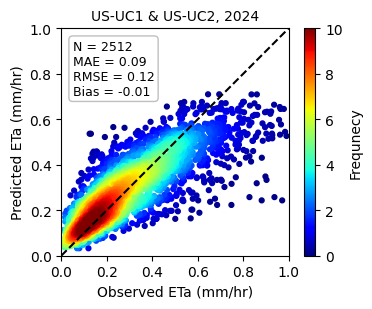

In [35]:
# Assuming df['actual'] and df['predicted'] exist
x = pd.concat([UC1_df_test_w_preds.loc['2024'], UC2_df_test_w_preds.loc['2024']])['ETa_corr'].values
y = pd.concat([UC1_df_test_w_preds.loc['2024'], UC2_df_test_w_preds.loc['2024']])['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequnecy')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-UC1 & US-UC2, 2024', fontsize=10)
#plt.legend()
plt.tight_layout()
#plt.savefig('US_UC1_2024_Actual_vs_Predcited_ETa_plot_with_colorbar.png', dpi=300, transparent=True)
plt.show()

### Test at test sites with tower data

In [ ]:
from scipy.stats import gaussian_kde

In [12]:
HWB_test_file_ECT = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_HWB_Hourly_ECT_PSNDVI_ETa_Scenario_B_ECT_train_AORC_testHWB2017.csv')  # Change to your test file path

UC1_test_file_ECT = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_UC1_Hourly_ECT_PSNDVI_ETa_Scenario_B_ECT_train_AORC_test_UC2024.csv')
UC2_test_file_ECT = os.path.join(os.path.dirname(os.getcwd()), '6_Data_aggregation',
                             'US_UC2_Hourly_ECT_PSNDVI_ETa_Scenario_B_ECT_train_AORC_testUC2024.csv')

# Load the data; ensure that the timestamp column is parsed as dates.
HWB_test_df_ECT = pd.read_csv(HWB_test_file_ECT, index_col=0, parse_dates=[0])
UC1_test_df_ECT = pd.read_csv(UC1_test_file_ECT, index_col=0, parse_dates=[0])
UC2_test_df_ECT = pd.read_csv(UC2_test_file_ECT, index_col=0, parse_dates=[0])

# Drop observations with nan NDVI values or ET_corr nan values
HWB_test_df_filtered = HWB_test_df_ECT[(HWB_test_df_ECT['NDVI']>0) & (HWB_test_df_ECT['ETa_corr']>0)]
UC1_test_df_filtered = UC1_test_df_ECT[(UC1_test_df_ECT['NDVI']>0) & (UC1_test_df_ECT['ETa_corr']>0)]
UC2_test_df_filtered = UC2_test_df_ECT[(UC2_test_df_ECT['NDVI']>0) & (UC2_test_df_ECT['ETa_corr']>0)]

HWB_test_df_filtered = HWB_test_df_filtered.rename(columns={'TA_1_1_1': 'Air_Temperature', 'RH_1_1_1': 'relative_humidity',
                                                      'SW_IN_1_1_1':'Downward_Short-Wave_Radiation_Flux'})
UC1_test_df_filtered = UC1_test_df_filtered.rename(columns={'TA_1_1_1': 'Air_Temperature', 'RH_1_1_1': 'relative_humidity',
                                                      'SW_IN_1_1_1':'Downward_Short-Wave_Radiation_Flux'})
UC2_test_df_filtered = UC2_test_df_filtered.rename(columns={'TA_1_1_1': 'Air_Temperature', 'RH_1_1_1': 'relative_humidity',
                                                      'SW_IN_1_1_1':'Downward_Short-Wave_Radiation_Flux'})

# List of input feature columns
input_features_list = ['NDVI',
 'Air_Temperature',
 'relative_humidity',
 'Downward_Short-Wave_Radiation_Flux']

# prediction of ETa for each pixel within tower ffp
HWB_X_test = HWB_test_df_filtered[input_features_list]
HWB_y_test = HWB_test_df_filtered['ETa_corr']

UC1_X_test = UC1_test_df_filtered[input_features_list]
UC1_y_test = UC1_test_df_filtered['ETa_corr']

UC2_X_test = UC2_test_df_filtered[input_features_list]
UC2_y_test = UC2_test_df_filtered['ETa_corr']

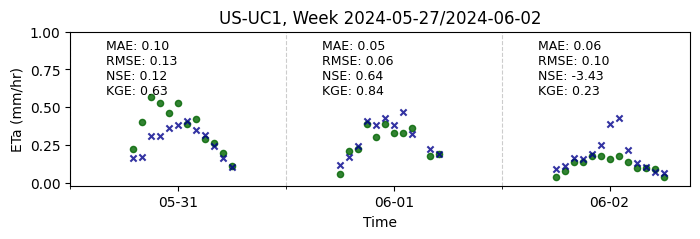

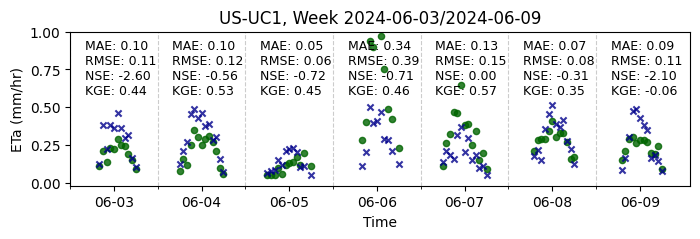

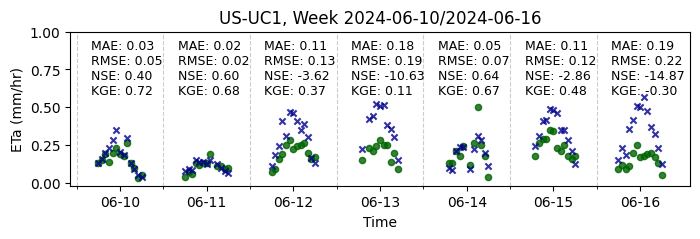

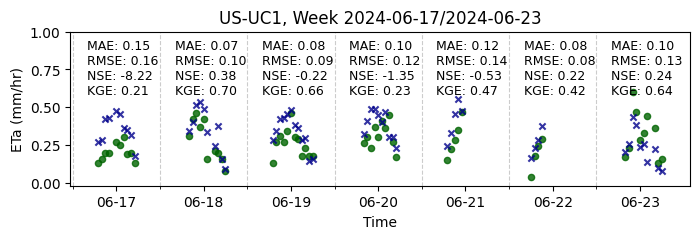

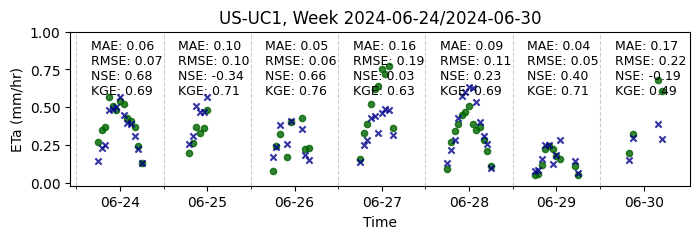

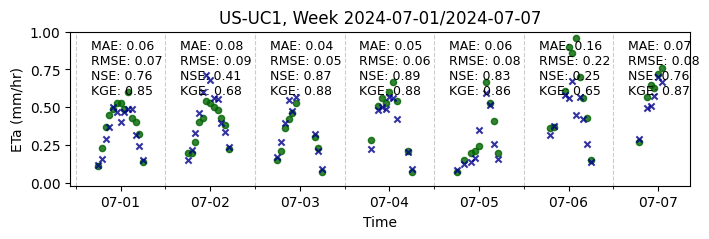

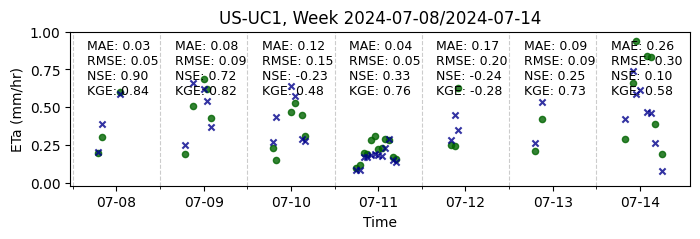

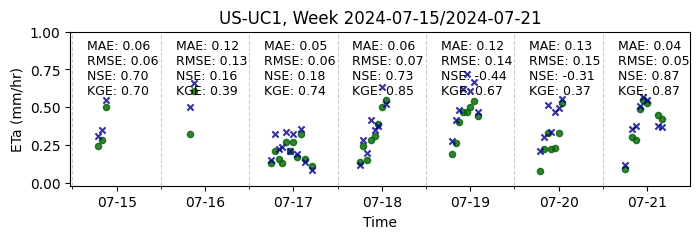

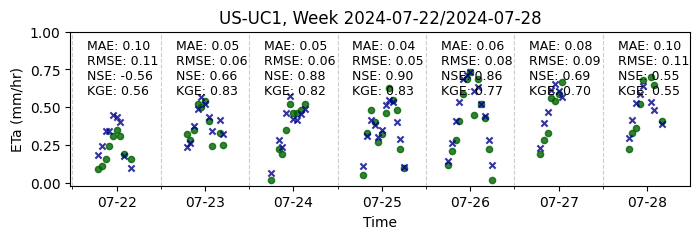

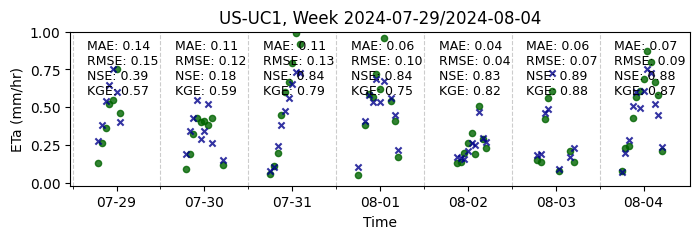

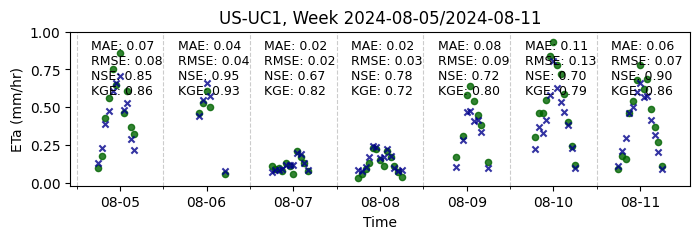

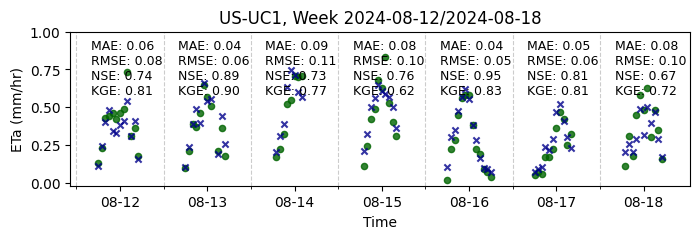

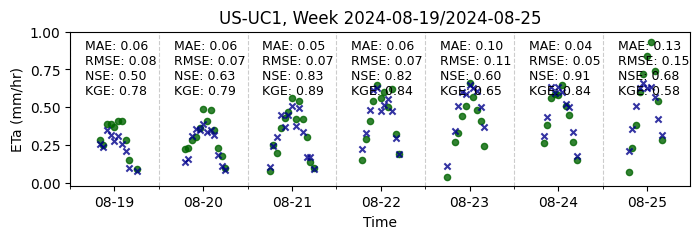

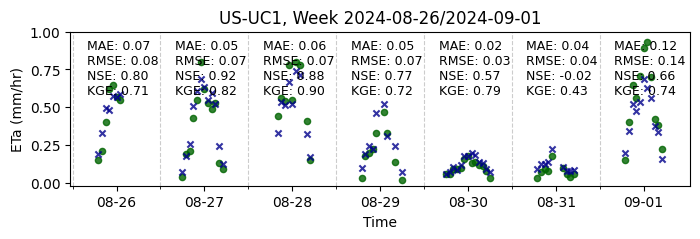

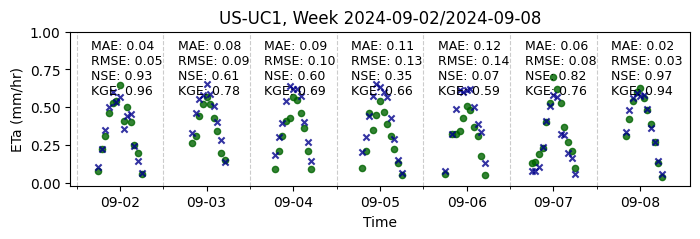

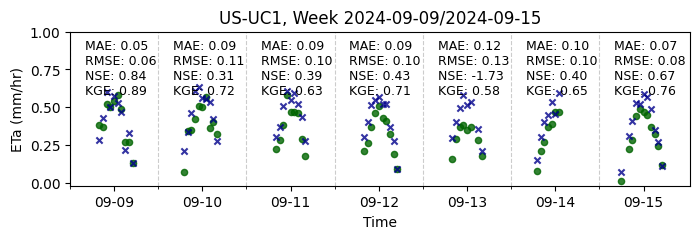

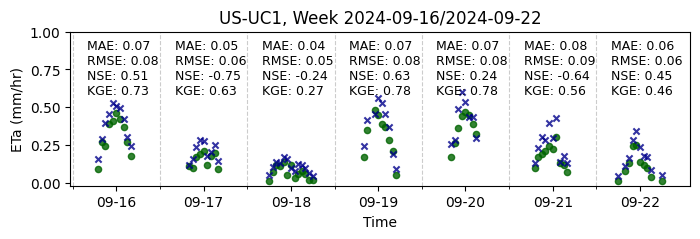

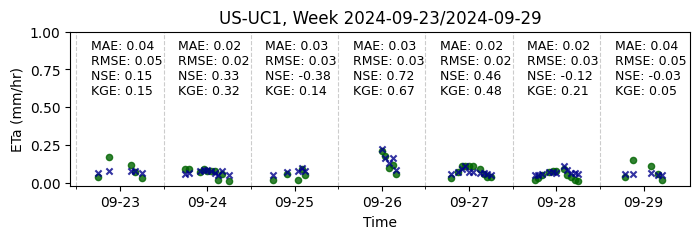

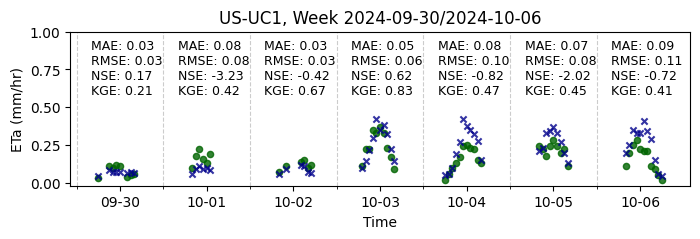

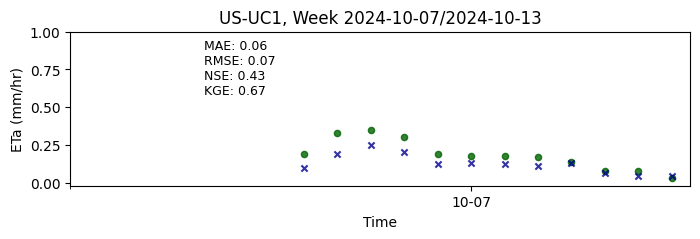

In [13]:
UC1_df_test_w_preds_ECT = predict_LGBM(lgbm_model, UC1_X_test, UC1_y_test, prediction_col='ETa_predicted')
weekly_plots_with_error_metrics(UC1_df_test_w_preds_ECT, 'ETa_corr', 'ETa_predicted', 'US-UC1', savefig=False)

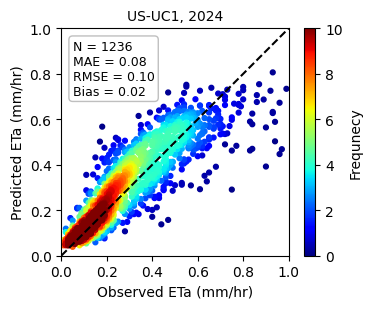

In [57]:

UC1_df_test_w_preds_ECT = UC1_df_test_w_preds_ECT.loc[UC1_df_test_w_preds.index]
# Assuming df['actual'] and df['predicted'] exist
x = UC1_df_test_w_preds_ECT.loc['2024']['ETa_corr'].values
y = UC1_df_test_w_preds_ECT.loc['2024']['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequnecy')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-UC1, 2024', fontsize=10)
#plt.legend()
plt.tight_layout()
plt.savefig('US_UC1_2024_Actual_vs_Predcited_ETa_plot_with_colorbar_ECT_input.png', dpi=300, transparent=True)
plt.show()

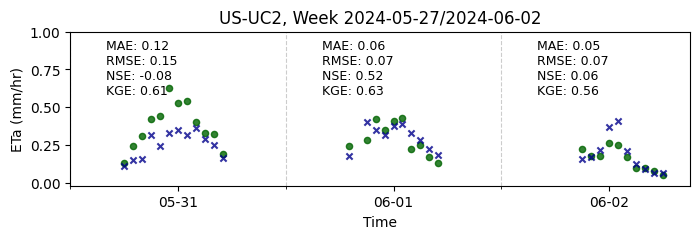

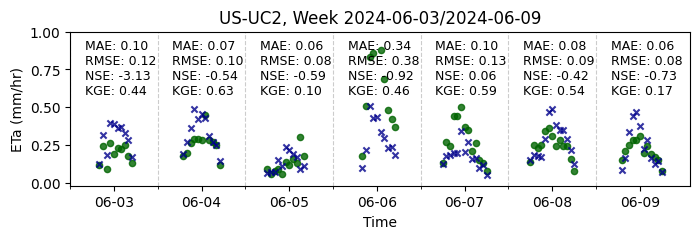

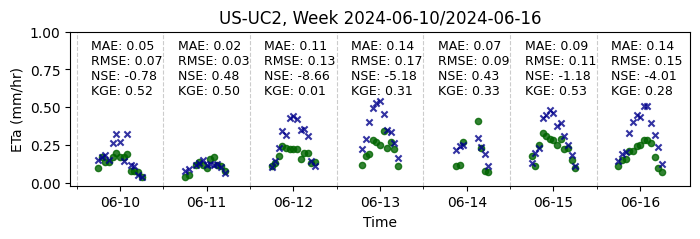

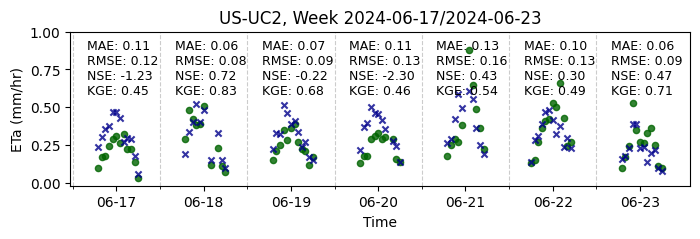

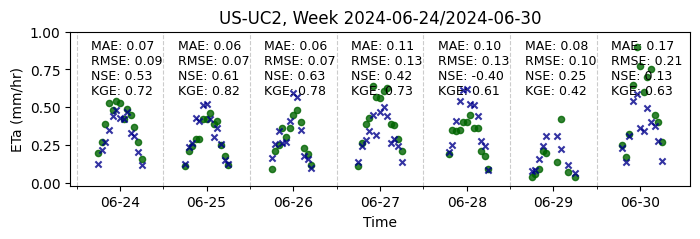

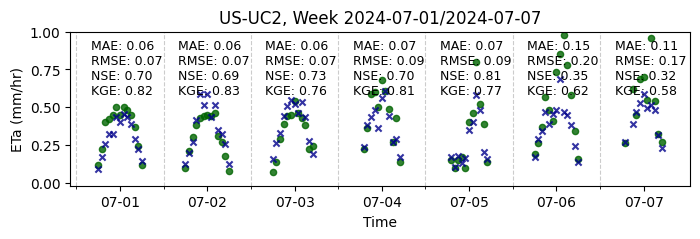

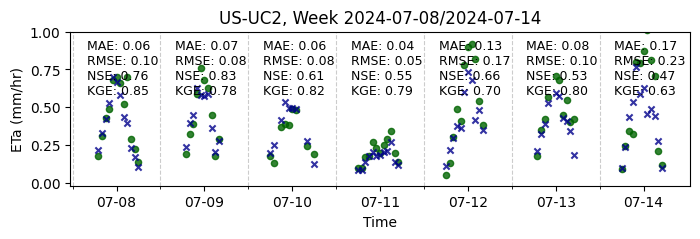

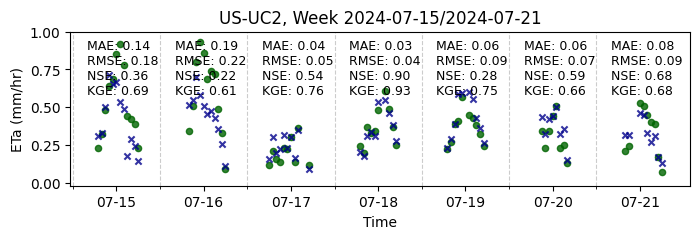

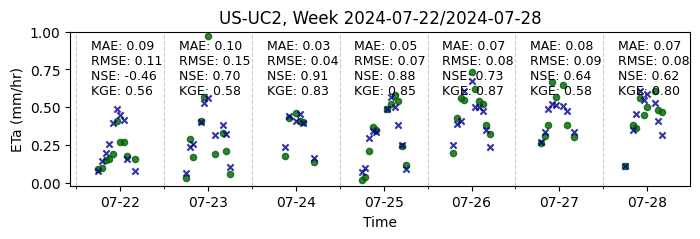

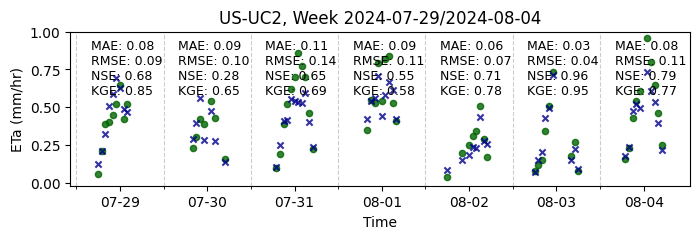

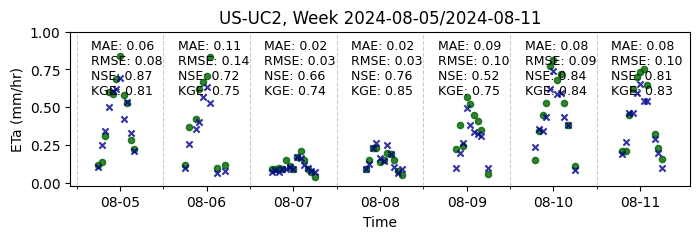

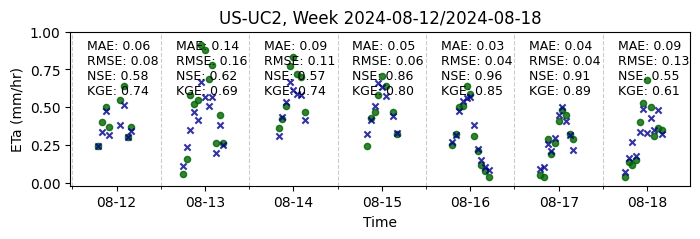

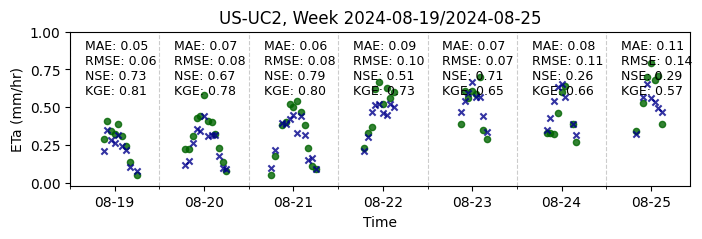

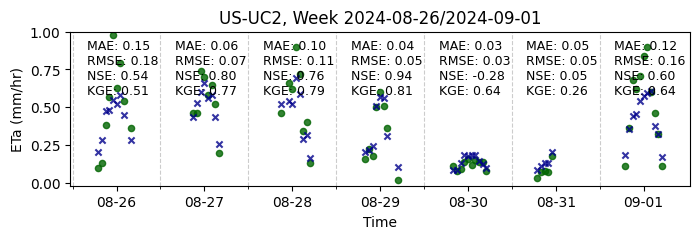

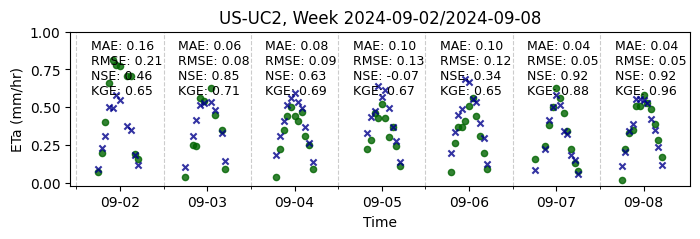

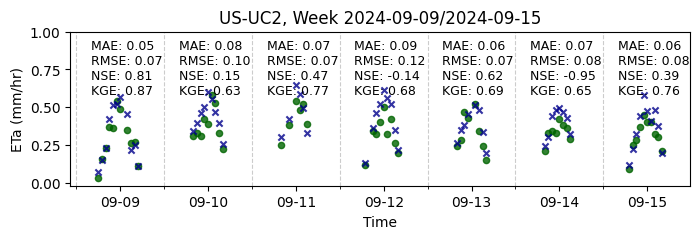

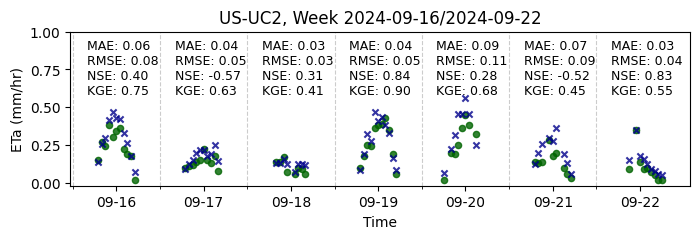

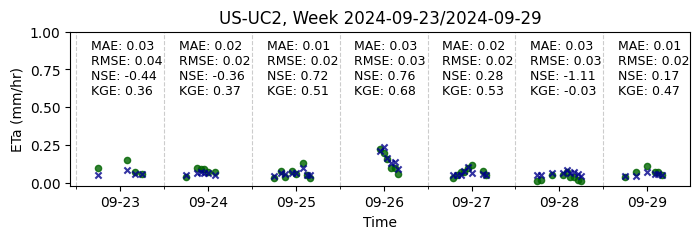

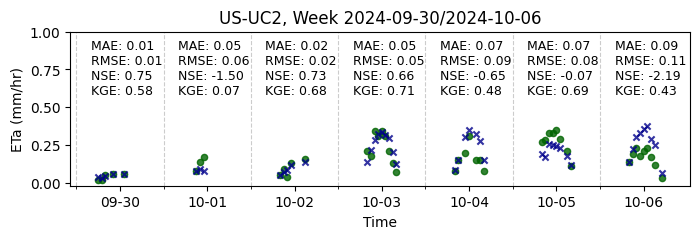

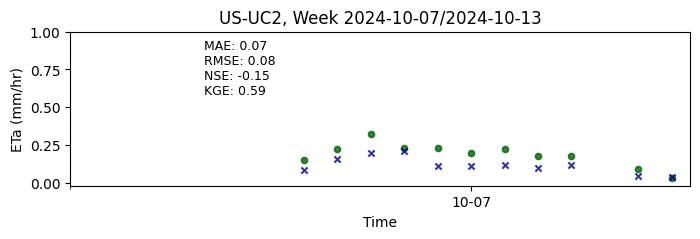

In [ ]:
UC2_df_test_w_preds_ECT = predict_LGBM(lgbm_model, UC2_X_test, UC2_y_test, prediction_col='ETa_predicted')
weekly_plots_with_error_metrics(UC2_df_test_w_preds_ECT, 'ETa_corr', 'ETa_predicted', 'US-UC2', savefig=False)

In [59]:
UC2_df_test_w_preds_ECT

NDVI  Air_Temperature  relative_humidity  \
2024-05-31 06:00:00  0.404964          7.49416           82.09395   
2024-05-31 07:00:00  0.409556         11.75570           61.08720   
2024-05-31 08:00:00  0.418533         14.36385           45.70350   
2024-05-31 09:00:00  0.427309         16.08455           39.40015   
2024-05-31 10:00:00  0.423594         17.26840           34.47445   
...                       ...              ...                ...   
2024-10-07 13:00:00  0.638772         15.15530           63.27120   
2024-10-07 14:00:00  0.637558         15.26885           60.57600   
2024-10-07 15:00:00  0.636831         15.13255           62.62350   
2024-10-07 17:00:00  0.634155         13.77280           67.52260   
2024-10-07 18:00:00  0.636405         12.78420           72.23975   

                     Downward_Short-Wave_Radiation_Flux  ETa_corr  \
2024-05-31 06:00:00                          283.413500      0.13   
2024-05-31 07:00:00                          478.869000      0.24   
2024-05-31 08:00:00                          671.131500      0.31   
2024-05-31 09:00:00                          828.390000      0.42   
2024-05-31 10:00:00                          941.024000      0.44   
...                                                 ...       ...   
2024-10-07 13:00:00                          223.496000      0.22   
2024-10-07 14:00:00                          116.082200      0.18   
2024-10-07 15:00:00                          182.241000      0.18   
2024-10-07 17:00:00                            8.829550      0.09   
2024-10-07 18:00:00                           -3.482545      0.03   

                     ETa_predicted  
2024-05-31 06:00:00       0.109733  
2024-05-31 07:00:00       0.153220  
2024-05-31 08:00:00       0.155472  
2024-05-31 09:00:00       0.315257  
2024-05-31 10:00:00       0.241372  
...                            ...  
2024-10-07 13:00:00       0.118773  
2024-10-07 14:00:00       0.094285  
2024-10-07 15:00:00       0.120403  
2024-10-07 17:00:00       0.042005  
2024-10-07 18:00:00       0.038529  

[1285 rows x 6 columns]

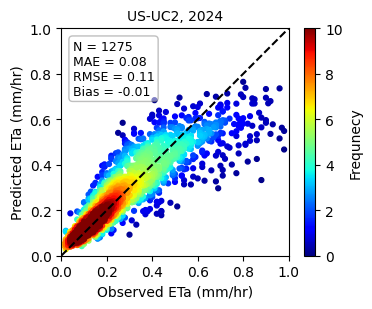

In [66]:
common_idx = UC2_df_test_w_preds_ECT.index.intersection(UC2_df_test_w_preds.index)
UC2_df_test_w_preds_ECT = UC2_df_test_w_preds_ECT.loc[common_idx]

# Assuming df['actual'] and df['predicted'] exist
x = UC2_df_test_w_preds_ECT.loc['2024']['ETa_corr'].values
y = UC2_df_test_w_preds_ECT.loc['2024']['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequnecy')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-UC2, 2024', fontsize=10)
#plt.legend()
plt.tight_layout()
plt.savefig('US_UC2_2024_Actual_vs_Predcited_ETa_plot_with_colorbar_ECT_input.png', dpi=300, transparent=True)
plt.show()

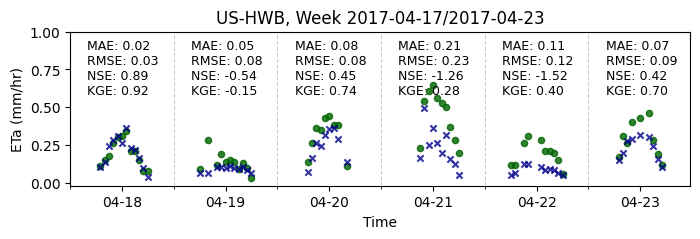

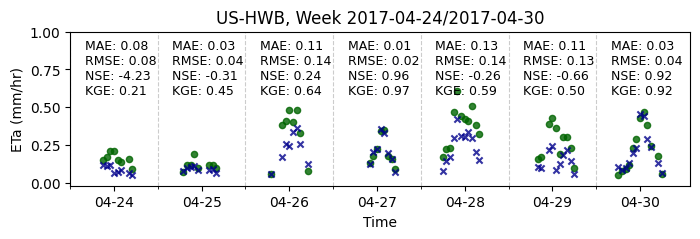

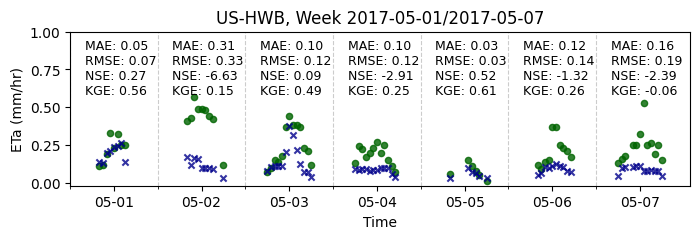

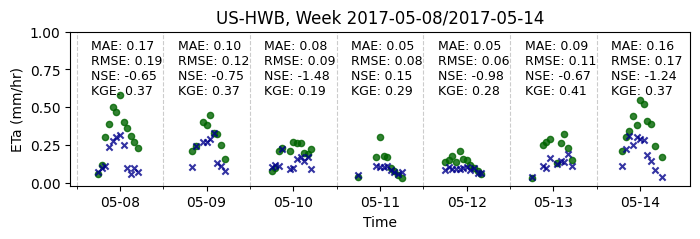

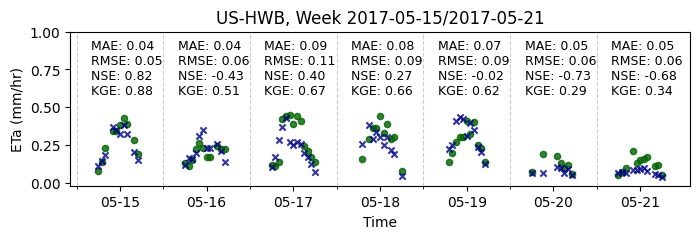

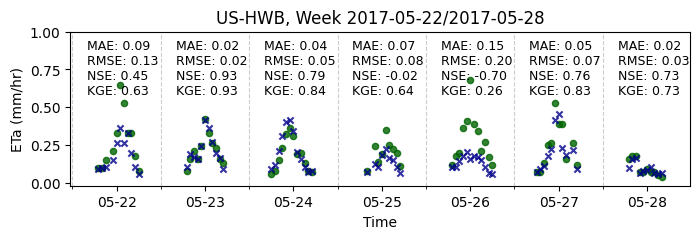

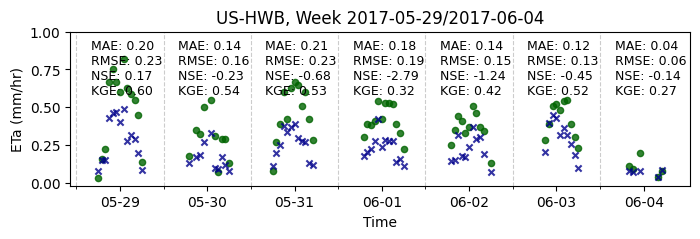

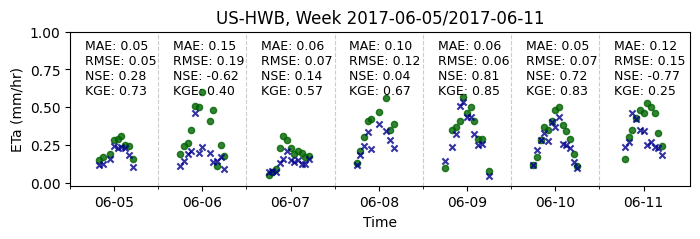

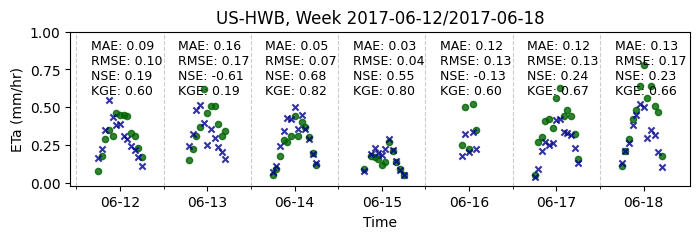

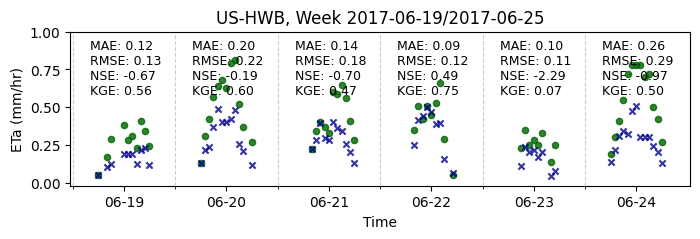

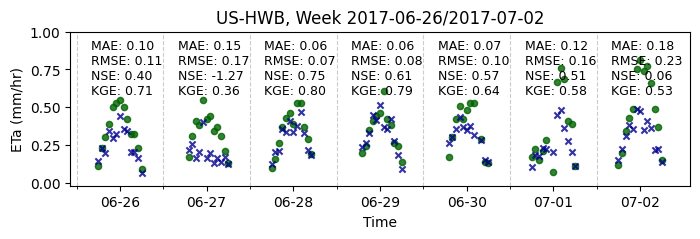

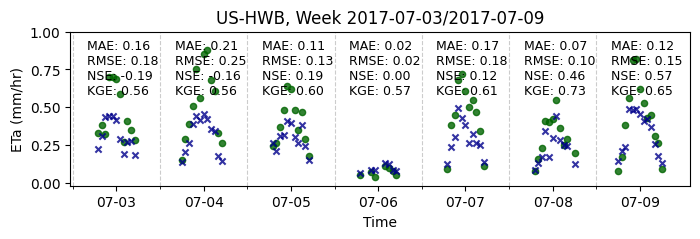

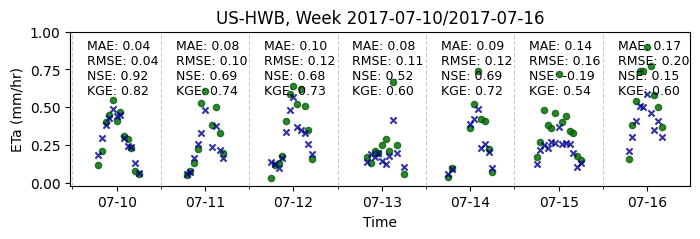

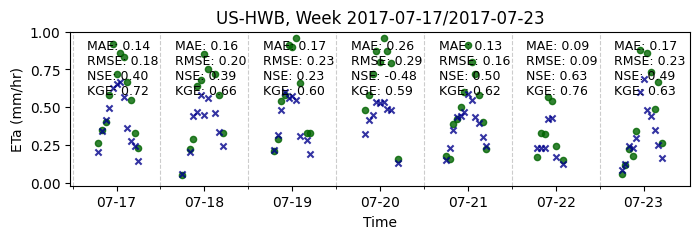

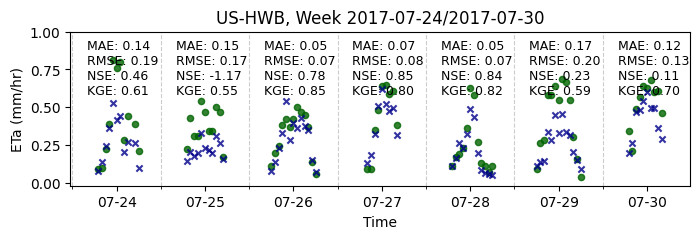

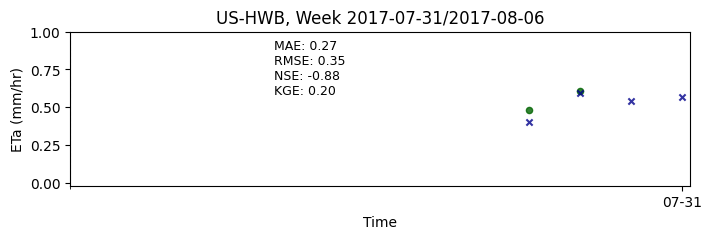

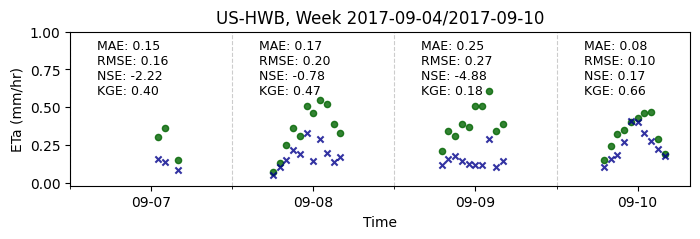

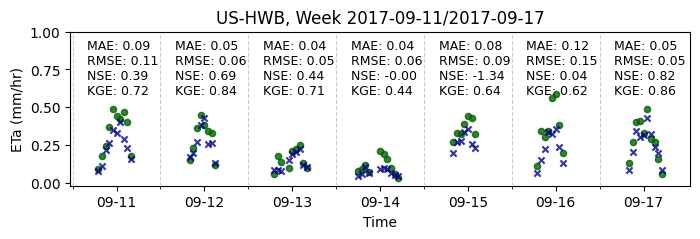

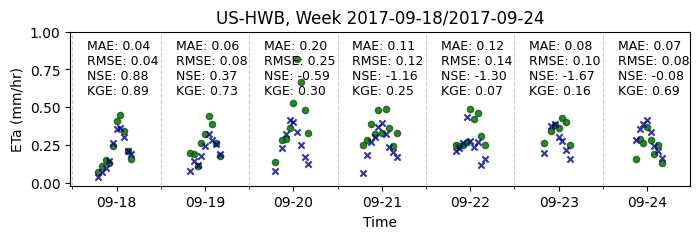

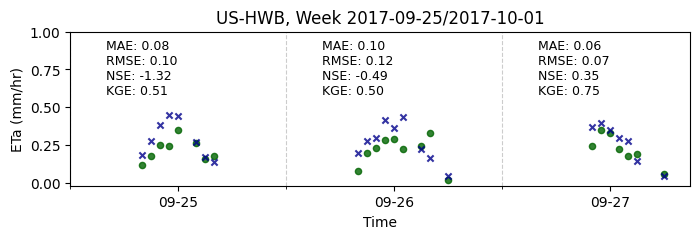

In [15]:
HWB_df_test_w_preds_ECT = predict_LGBM(lgbm_model, HWB_X_test, HWB_y_test, prediction_col='ETa_predicted')
weekly_plots_with_error_metrics(HWB_df_test_w_preds_ECT, 'ETa_corr', 'ETa_predicted', 'US-HWB', savefig=False)

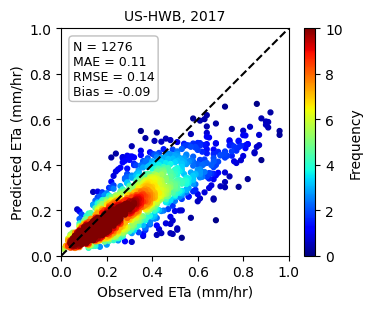

In [67]:
common_idx = HWB_df_test_w_preds_ECT.index.intersection(HWB_df_test_w_preds.index)
HWB_df_test_w_preds_ECT = HWB_df_test_w_preds_ECT.loc[common_idx]

# Assuming df['actual'] and df['predicted'] exist
x = HWB_df_test_w_preds_ECT.loc['2017']['ETa_corr'].values
y = HWB_df_test_w_preds_ECT.loc['2017']['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequency')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-HWB, 2017', fontsize=10)
#plt.legend()
plt.tight_layout()
plt.savefig('US_HWB_2017_Actual_vs_Predcited_ETa_plot_with_colorbar_ECT_input.png', dpi=300, transparent=True)
plt.show()

#### UC1 and 2 together

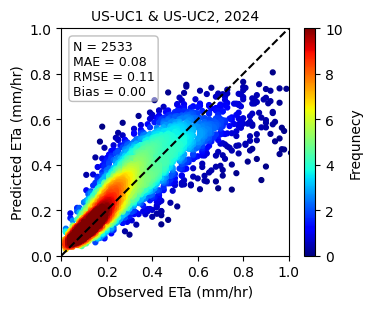

In [30]:
# Assuming df['actual'] and df['predicted'] exist
x = pd.concat([UC1_df_test_w_preds_ECT.loc['2024'], UC2_df_test_w_preds_ECT.loc['2024']])['ETa_corr'].values
y = pd.concat([UC1_df_test_w_preds_ECT.loc['2024'], UC2_df_test_w_preds_ECT.loc['2024']])['ETa_predicted'].values

# Stack them and calculate the point density
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
kde.set_bandwidth(bw_method=0.28)
z = kde(xy)  # z is the density estimate

# Optional: sort so densest points are plotted last (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

z_percent = 100.0 * z / z.max()

# Error metrics
n = len(x)
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = np.sqrt(mean_squared_error(x, y))
bias = np.mean(y - x)

# Plot
plt.figure(figsize=(4,3.2))
sc = plt.scatter(x, y, c=z, cmap='jet', s=12, vmin=0, vmax=10)
plt.colorbar(sc, label='Frequnecy')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

textstr = f'N = {n}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\nBias = {bias:0.2f}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,  # Use axes coords (0–1)
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray',alpha=0.5)
)

# Set square plot area
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Observed ETa (mm/hr)')
plt.ylabel('Predicted ETa (mm/hr)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('US-UC1 & US-UC2, 2024', fontsize=10)
#plt.legend()
plt.tight_layout()
#plt.savefig('US_UC1_2024_Actual_vs_Predcited_ETa_plot_with_colorbar.png', dpi=300, transparent=True)
plt.show()

### Compare the error from ECT inputs and AORC inputs

In [ ]:
common_idx = HWB_df_test_w_preds_ECT.index.intersection(HWB_df_test_w_preds.index)
HWB_df_test_w_preds_ECT = HWB_df_test_w_preds_ECT.loc[common_idx]

common_idx = UC1_df_test_w_preds_ECT.index.intersection(UC1_df_test_w_preds.index)
UC1_df_test_w_preds_ECT = UC1_df_test_w_preds_ECT.loc[common_idx]

common_idx = UC2_df_test_w_preds_ECT.index.intersection(UC2_df_test_w_preds.index)
UC2_df_test_w_preds_ECT = UC2_df_test_w_preds_ECT.loc[common_idx]

In [ ]:
HWB_df_test_w_preds_ECT.loc[HWB_df_test_w_preds.index]

NDVI  Air_Temperature  relative_humidity  \
2017-04-18 07:00:00  0.303193         9.557455           67.29785   
2017-04-18 08:00:00  0.333696        11.311700           59.42775   
2017-04-18 09:00:00  0.310348        13.448300           52.30245   
2017-04-18 10:00:00  0.310426        15.515750           44.80905   
2017-04-18 11:00:00  0.305896        17.169750           38.32835   
...                       ...              ...                ...   
2017-09-27 12:00:00  0.230709        32.256000           51.69665   
2017-09-27 13:00:00  0.247192        32.246600           46.01955   
2017-09-27 14:00:00  0.253408        32.365350           42.46880   
2017-09-27 15:00:00  0.256250        30.880350           48.99480   
2017-09-27 18:00:00  0.251365        28.333000           47.53310   

                     Downward_Short-Wave_Radiation_Flux  ETa_corr  \
2017-04-18 07:00:00                          347.997000      0.11   
2017-04-18 08:00:00                          539.009500      0.15   
2017-04-18 09:00:00                          708.534500      0.18   
2017-04-18 10:00:00                          833.323500      0.26   
2017-04-18 11:00:00                          909.538500      0.30   
...                                                 ...       ...   
2017-09-27 12:00:00                          595.941500      0.33   
2017-09-27 13:00:00                          605.803000      0.22   
2017-09-27 14:00:00                          547.940000      0.18   
2017-09-27 15:00:00                          170.603500      0.19   
2017-09-27 18:00:00                           -1.555131      0.06   

                     ETa_predicted  
2017-04-18 07:00:00       0.105324  
2017-04-18 08:00:00       0.140059  
2017-04-18 09:00:00       0.240111  
2017-04-18 10:00:00       0.282251  
2017-04-18 11:00:00       0.308317  
...                            ...  
2017-09-27 12:00:00       0.351185  
2017-09-27 13:00:00       0.298576  
2017-09-27 14:00:00       0.272961  
2017-09-27 15:00:00       0.142404  
2017-09-27 18:00:00       0.041938  

[1276 rows x 6 columns]

In [52]:
HWB_df_test_w_preds_ECT.index.difference(HWB_df_test_w_preds.index)

DatetimeIndex(['2017-05-01 12:00:00', '2017-06-14 11:00:00',
               '2017-07-23 12:00:00', '2017-07-31 11:00:00',
               '2017-07-31 12:00:00', '2017-09-09 14:00:00'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
HWB_df_test_w_preds[['ETa_predicted']]

NDVI  Air Temperature  relative_humidity  \
2017-04-18 07:00:00  0.303193             7.85          71.455276   
2017-04-18 08:00:00  0.333696            10.35          64.137604   
2017-04-18 09:00:00  0.310348            11.75          59.604284   
2017-04-18 10:00:00  0.310426            13.75          52.309720   
2017-04-18 11:00:00  0.305896            15.85          44.758416   
...                       ...              ...                ...   
2017-09-27 12:00:00  0.230709            29.25          58.981821   
2017-09-27 13:00:00  0.247192            29.45          55.292908   
2017-09-27 14:00:00  0.253408            30.95          49.339781   
2017-09-27 15:00:00  0.256250            31.05          46.983514   
2017-09-27 18:00:00  0.251365            25.95          59.972153   

                     Downward Short-Wave Radiation Flux  ETa_corr  \
2017-04-18 07:00:00                               237.1  0.109366   
2017-04-18 08:00:00                               393.0  0.154087   
2017-04-18 09:00:00                               550.8  0.179060   
2017-04-18 10:00:00                               696.9  0.256576   
2017-04-18 11:00:00                               797.9  0.295471   
...                                                 ...       ...   
2017-09-27 12:00:00                               652.3  0.331189   
2017-09-27 13:00:00                               638.3  0.215717   
2017-09-27 14:00:00                               557.8  0.179160   
2017-09-27 15:00:00                               442.0  0.185544   
2017-09-27 18:00:00                                 0.0  0.056375   

                     ETa_predicted  
2017-04-18 07:00:00       0.117424  
2017-04-18 08:00:00       0.153675  
2017-04-18 09:00:00       0.114023  
2017-04-18 10:00:00       0.220524  
2017-04-18 11:00:00       0.280771  
...                            ...  
2017-09-27 12:00:00       0.365655  
2017-09-27 13:00:00       0.417165  
2017-09-27 14:00:00       0.314867  
2017-09-27 15:00:00       0.220396  
2017-09-27 18:00:00       0.046649  

[1276 rows x 6 columns]

In [50]:
HWB_df_test_w_preds_ECT

NDVI  Air_Temperature  relative_humidity  \
2017-04-18 07:00:00  0.303193         9.557455           67.29785   
2017-04-18 08:00:00  0.333696        11.311700           59.42775   
2017-04-18 09:00:00  0.310348        13.448300           52.30245   
2017-04-18 10:00:00  0.310426        15.515750           44.80905   
2017-04-18 11:00:00  0.305896        17.169750           38.32835   
...                       ...              ...                ...   
2017-09-27 12:00:00  0.230709        32.256000           51.69665   
2017-09-27 13:00:00  0.247192        32.246600           46.01955   
2017-09-27 14:00:00  0.253408        32.365350           42.46880   
2017-09-27 15:00:00  0.256250        30.880350           48.99480   
2017-09-27 18:00:00  0.251365        28.333000           47.53310   

                     Downward_Short-Wave_Radiation_Flux  ETa_corr  \
2017-04-18 07:00:00                          347.997000      0.11   
2017-04-18 08:00:00                          539.009500      0.15   
2017-04-18 09:00:00                          708.534500      0.18   
2017-04-18 10:00:00                          833.323500      0.26   
2017-04-18 11:00:00                          909.538500      0.30   
...                                                 ...       ...   
2017-09-27 12:00:00                          595.941500      0.33   
2017-09-27 13:00:00                          605.803000      0.22   
2017-09-27 14:00:00                          547.940000      0.18   
2017-09-27 15:00:00                          170.603500      0.19   
2017-09-27 18:00:00                           -1.555131      0.06   

                     ETa_predicted  
2017-04-18 07:00:00       0.105324  
2017-04-18 08:00:00       0.140059  
2017-04-18 09:00:00       0.240111  
2017-04-18 10:00:00       0.282251  
2017-04-18 11:00:00       0.308317  
...                            ...  
2017-09-27 12:00:00       0.351185  
2017-09-27 13:00:00       0.298576  
2017-09-27 14:00:00       0.272961  
2017-09-27 15:00:00       0.142404  
2017-09-27 18:00:00       0.041938  

[1282 rows x 6 columns]